# Von Karman Vortex Street - Validation Against CFD Ground Truth

This notebook validates the viscous vortex method implementation (`VortexAmp`) against 
high-fidelity CFD simulation data from the ETH Zurich visualization dataset.

## Ground Truth Dataset
- **Source**: [ETH Zurich CGL Visualization Data](https://cgl.ethz.ch/research/visualization/data.php)
- **Solver**: Gerris Flow Solver (adaptive mesh refinement)
- **Grid**: 640 x 80 x 1501 (resampled to regular grid)
- **Domain**: [-0.5, 7.5] x [-0.5, 0.5] x [0, 15]
- **Reynolds Number**: 160
- **Kinematic Viscosity**: 0.00078125
- **Cylinder**: radius = 0.0625 (diameter = 0.125), centered at origin

## Table of Contents
1. [Setup and Imports](#1.-Setup-and-Imports)
2. [Ground Truth Parameters](#2.-Ground-Truth-Parameters)
3. [Load CFD Ground Truth Data](#3.-Load-CFD-Ground-Truth-Data)
4. [Run Vortex Method Simulation](#4.-Run-Vortex-Method-Simulation)
5. [Side-by-Side Comparison](#5.-Side-by-Side-Comparison)
   - 5a. Velocity Field Comparison
   - 5b. Error Field Analysis
   - 5c. Probe Time Series Comparison
6. [Quantitative Analysis](#6.-Quantitative-Analysis)
   - Strouhal Number Comparison (CFD vs VM vs Theory)
   - Power Spectral Density Analysis
   - Final Summary

---
## 1. Setup and Imports

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.gridspec import GridSpec
import netCDF4 as nc
from scipy import signal
from scipy.interpolate import RegularGridInterpolator
import os

from von_karman_simulator import VortexAmp, compute_velocity_field, compute_strouhal_number
import plotting

# Plot settings
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Create output folder
OUTPUT_DIR = '../output/validation'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {os.path.abspath(OUTPUT_DIR)}")

Output directory: c:\Projects\von-karman\output\validation


---
## 2. Ground Truth Parameters

Extract and define all physical parameters from the CFD dataset to ensure an identical simulation setup.

In [36]:
# =============================================================================
# GROUND TRUTH PARAMETERS (from ETH Zurich CFD dataset)
# =============================================================================

# Geometry
CYLINDER_RADIUS = 0.0625      # [m] obstacle radius
CYLINDER_DIAMETER = 2 * CYLINDER_RADIUS  # = 0.125 [m]
CYLINDER_X = 0.0              # [m] cylinder center x-coordinate
CYLINDER_Y = 0.0              # [m] cylinder center y-coordinate

# Domain
X_MIN, X_MAX = -0.5, 7.5      # [m] streamwise extent
Y_MIN, Y_MAX = -0.5, 0.5      # [m] transverse extent
T_MIN, T_MAX = 0.0, 15.0      # [s] time extent

# Physical properties
NU = 0.00078125               # [m^2/s] kinematic viscosity
RE = 160                      # [-] Reynolds number

# Derived: freestream velocity from Re = U*D/nu
U_INF = RE * NU / CYLINDER_DIAMETER  # = 1.0 [m/s]

# Expected Strouhal number at Re=160 (Roshko correlation)
ST_THEORETICAL = compute_strouhal_number(RE)

# Define cylinder for VortexAmp
cylinders = [{'x': CYLINDER_X, 'y': CYLINDER_Y, 'D': CYLINDER_DIAMETER}]

# Print summary
print("=" * 60)
print("VALIDATION EXPERIMENT PARAMETERS")
print("=" * 60)
print(f"\nGeometry:")
print(f"  Cylinder diameter D = {CYLINDER_DIAMETER:.4f} m")
print(f"  Cylinder position   = ({CYLINDER_X}, {CYLINDER_Y}) m")
print(f"\nDomain:")
print(f"  x: [{X_MIN}, {X_MAX}] m  (length = {X_MAX - X_MIN} m)")
print(f"  y: [{Y_MIN}, {Y_MAX}] m  (height = {Y_MAX - Y_MIN} m)")
print(f"  t: [{T_MIN}, {T_MAX}] s")
print(f"\nPhysics:")
print(f"  Kinematic viscosity nu = {NU:.8f} m^2/s")
print(f"  Reynolds number Re     = {RE}")
print(f"  Freestream velocity U  = {U_INF:.4f} m/s")
print(f"  Strouhal number St     = {ST_THEORETICAL:.4f} (Roshko correlation)")
print(f"\nExpected shedding frequency:")
f_shedding = ST_THEORETICAL * U_INF / CYLINDER_DIAMETER
T_shedding = 1.0 / f_shedding
print(f"  f = St * U / D = {f_shedding:.4f} Hz")
print(f"  T = 1/f = {T_shedding:.4f} s")
print("=" * 60)

VALIDATION EXPERIMENT PARAMETERS

Geometry:
  Cylinder diameter D = 0.1250 m
  Cylinder position   = (0.0, 0.0) m

Domain:
  x: [-0.5, 7.5] m  (length = 8.0 m)
  y: [-0.5, 0.5] m  (height = 1.0 m)
  t: [0.0, 15.0] s

Physics:
  Kinematic viscosity nu = 0.00078125 m^2/s
  Reynolds number Re     = 160
  Freestream velocity U  = 1.0000 m/s
  Strouhal number St     = 0.1839 (Roshko correlation)

Expected shedding frequency:
  f = St * U / D = 1.4713 Hz
  T = 1/f = 0.6797 s


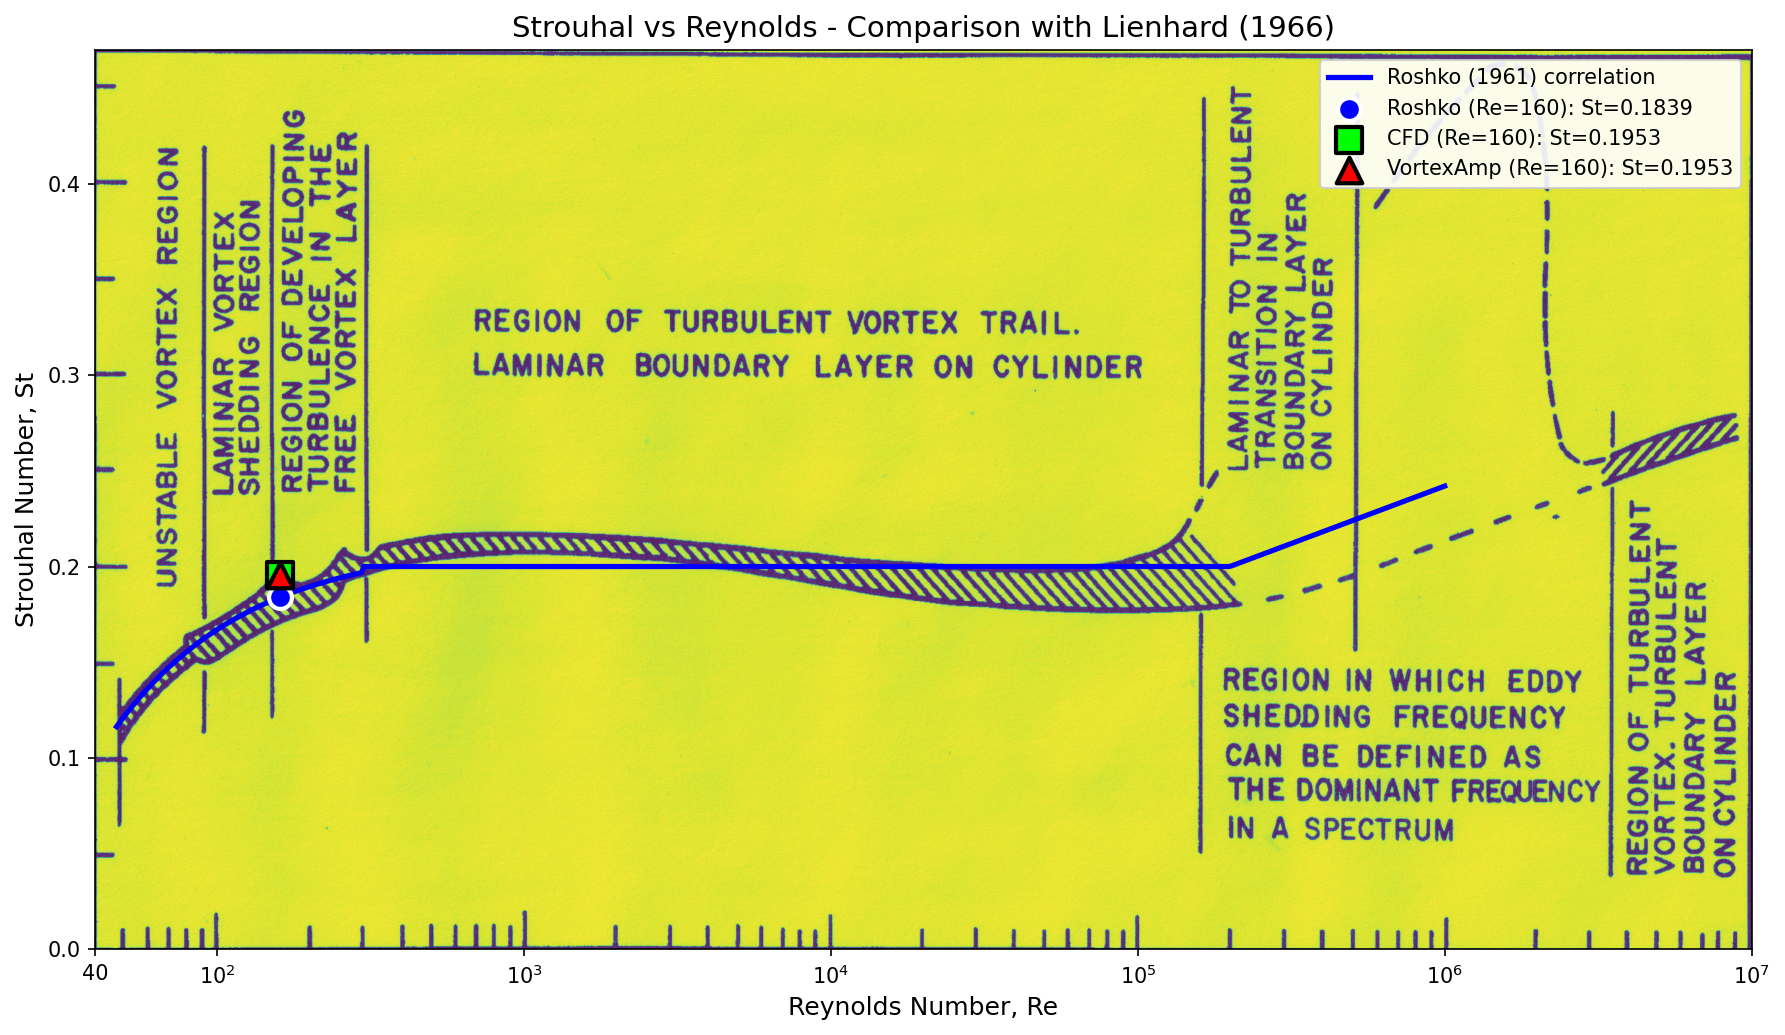

In [37]:
# Plot Strouhal vs Reynolds overlaid on Lienhard (1966) literature graph
from PIL import Image

# Load the Lienhard graph
img = Image.open('../data/lienhard_graph.jpg')
img_array = np.array(img)

# =============================================================================
# MANUAL IMAGE ALIGNMENT - Adjust these values to align the image axes
# =============================================================================
# Pixel coordinates of the DATA AREA in the image (not the whole image)
# Adjust these until the axes align with your data points
IMG_LEFT = 225      # pixels from left edge to y-axis
IMG_RIGHT = 2680    # pixels from left edge to right edge of plot
IMG_TOP = 55       # pixels from top edge to top of plot  
IMG_BOTTOM = 1260   # pixels from top edge to x-axis

# Data range of the Lienhard graph
RE_MIN, RE_MAX = 40, 1e7      # Reynolds number range (log scale)
ST_MIN, ST_MAX = 0, 0.47      # Strouhal number range (linear scale)
# =============================================================================

# Crop image to just the data area
img_cropped = img_array[IMG_TOP:IMG_BOTTOM, IMG_LEFT:IMG_RIGHT]

fig, ax = plt.subplots(figsize=(12, 7))

# Display cropped image as background
ax.imshow(img_cropped, extent=[np.log10(RE_MIN), np.log10(RE_MAX), ST_MIN, ST_MAX], 
          aspect='auto', alpha=0.9, zorder=0)

# Plot Roshko correlation curve on top
compute_strouhal_vectorized = np.vectorize(compute_strouhal_number)
RE_values = np.logspace(np.log10(47), np.log10(1e6), 500)
ST_values = compute_strouhal_vectorized(RE_values)
ax.plot(np.log10(RE_values), ST_values, 'b-', linewidth=2.5, label='Roshko (1961) correlation', zorder=2)

# Plot theoretical point for current RE
ax.scatter(np.log10(RE), ST_THEORETICAL, s=120, c='blue', marker='o', edgecolors='white', 
           linewidths=2, zorder=5, label=f'Roshko (Re={RE}): St={ST_THEORETICAL:.4f}')

# Add measured data points if available (computed in later cells)
if 'cfd_St_measured' in dir():
    ax.scatter(np.log10(RE), cfd_St_measured, s=150, c='lime', marker='s', edgecolors='black', 
               linewidths=2, zorder=5, label=f'CFD (Re={RE}): St={cfd_St_measured:.4f}')
if 'vm_St_measured' in dir():
    ax.scatter(np.log10(RE), vm_St_measured, s=150, c='red', marker='^', edgecolors='black', 
               linewidths=2, zorder=5, label=f'VortexAmp (Re={RE}): St={vm_St_measured:.4f}')

# Format axes
ax.set_xlim(np.log10(RE_MIN), np.log10(RE_MAX))
ax.set_ylim(ST_MIN, ST_MAX)

# Custom x-tick labels showing actual Re values
xtick_values = [40, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
ax.set_xticks([np.log10(x) for x in xtick_values])
ax.set_xticklabels(['40', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$'])

ax.set_xlabel('Reynolds Number, Re', fontsize=12)
ax.set_ylabel('Strouhal Number, St', fontsize=12)
ax.set_title('Strouhal vs Reynolds - Comparison with Lienhard (1966)', fontsize=14)
ax.legend(loc='upper right', fontsize=10, facecolor='white', framealpha=0.9)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/09_strouhal_vs_reynolds_lienhard.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 3. Load CFD Ground Truth Data

In [38]:
# Load NetCDF dataset
cfd_path = '../data/cylinder2d_nc/cylinder2d.nc'
ds = nc.Dataset(cfd_path)

print("CFD Dataset Contents:")
print(f"  Variables: {list(ds.variables.keys())}")
print(f"\nDimensions:")
for dim_name, dim in ds.dimensions.items():
    print(f"  {dim_name}: {len(dim)}")

CFD Dataset Contents:
  Variables: ['u', 'v', 'xdim', 'ydim', 'tdim', 'nu', 'radius', 'Re']

Dimensions:
  xdim: 640
  ydim: 80
  tdim: 1501
  const: 1


In [39]:
# Extract coordinate arrays
cfd_x = ds.variables['xdim'][:]
cfd_y = ds.variables['ydim'][:]
cfd_t = ds.variables['tdim'][:]
cfd_X, cfd_Y = np.meshgrid(cfd_x, cfd_y)

# Verify parameters match
cfd_radius = ds.variables['radius'][:][0]
cfd_Re = ds.variables['Re'][:][0]
cfd_nu = ds.variables['nu'][:][0]

print("CFD Dataset Parameters (verification):")
print(f"  Radius: {cfd_radius} (expected: {CYLINDER_RADIUS})")
print(f"  Re: {cfd_Re} (expected: {RE})")
print(f"  nu: {cfd_nu} (expected: {NU})")
print(f"\nGrid info:")
print(f"  x: [{cfd_x.min():.2f}, {cfd_x.max():.2f}], nx={len(cfd_x)}")
print(f"  y: [{cfd_y.min():.2f}, {cfd_y.max():.2f}], ny={len(cfd_y)}")
print(f"  t: [{cfd_t.min():.2f}, {cfd_t.max():.2f}], nt={len(cfd_t)}")

CFD Dataset Parameters (verification):
  Radius: 0.0625 (expected: 0.0625)
  Re: 160.0 (expected: 160)
  nu: 0.0007812500116415322 (expected: 0.00078125)

Grid info:
  x: [-0.50, 7.50], nx=640
  y: [-0.50, 0.50], ny=80
  t: [0.00, 15.00], nt=1501


In [40]:
# Select a timestep where the vortex street is fully developed
# (later in the simulation, after initial transient)
CFD_TIMESTEP = 1000  # corresponds to t ~ 10s

cfd_u = ds.variables['u'][CFD_TIMESTEP, :, :]
cfd_v = ds.variables['v'][CFD_TIMESTEP, :, :]
cfd_vel_mag = np.sqrt(cfd_u**2 + cfd_v**2)
cfd_time = cfd_t[CFD_TIMESTEP]

print(f"Selected CFD timestep: {CFD_TIMESTEP}")
print(f"  Simulation time: t = {cfd_time:.2f} s")
print(f"  Velocity magnitude range: [{cfd_vel_mag.min():.3f}, {cfd_vel_mag.max():.3f}] m/s")

Selected CFD timestep: 1000
  Simulation time: t = 10.00 s
  Velocity magnitude range: [0.000, 1.557] m/s


c:\Users\cprim\miniconda3\envs\sandbox-env\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\2182121042.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((0, 0), radius, color='gray', fill=True, zorder=10,


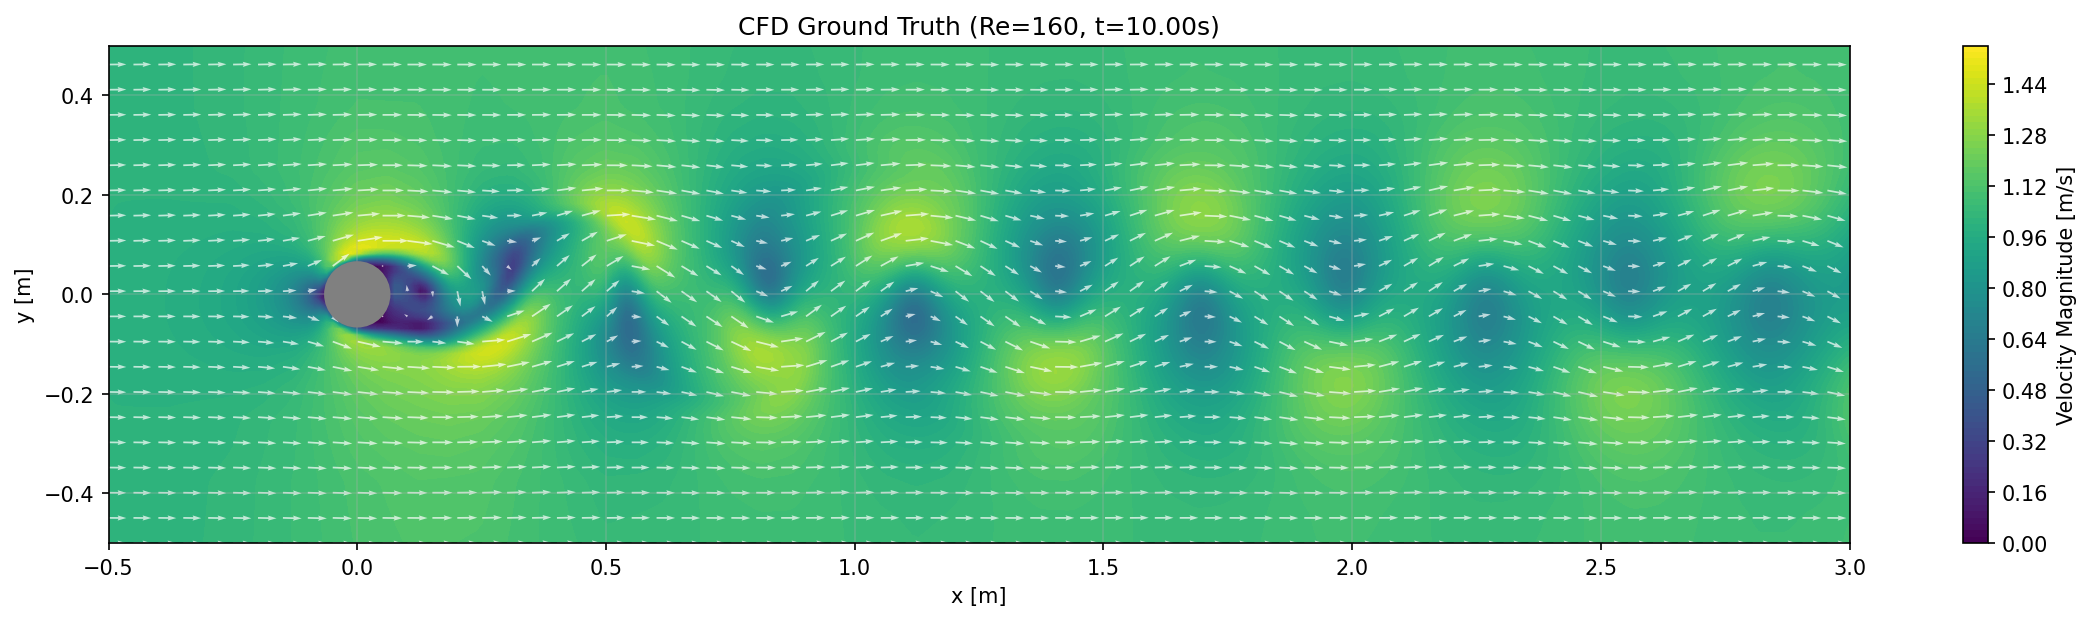

In [41]:
def plot_cfd_velocity_field(X, Y, u, v, radius, time, Re, ax=None, title=None):
    """Plot CFD velocity field with cylinder."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 4))
    
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Velocity magnitude contour
    contour = ax.contourf(X, Y, vel_mag, levels=100, cmap='viridis')
    plt.colorbar(contour, ax=ax, label='Velocity Magnitude [m/s]')
    
    # Quiver plot
    skip = 4
    scale_ref = np.percentile(vel_mag, 95)
    ax.quiver(X[::skip, ::skip], Y[::skip, ::skip],
              u[::skip, ::skip], v[::skip, ::skip],
              color='white', alpha=0.7, scale=scale_ref*80, width=0.001)
    
    # Draw cylinder
    circle = Circle((0, 0), radius, color='gray', fill=True, zorder=10,
                     edgecolor='black', linewidth=2)
    ax.add_patch(circle)
    
    # Formatting
    ax.set_xlim(X.min(), 3)  # Focus on near-wake region
    ax.set_ylim(Y.min(), Y.max())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'CFD Ground Truth (Re={Re:.0f}, t={time:.2f}s)')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot CFD ground truth
fig, ax = plt.subplots(figsize=(16, 4))
plot_cfd_velocity_field(cfd_X, cfd_Y, cfd_u, cfd_v, cfd_radius, cfd_time, cfd_Re, ax=ax)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_cfd_ground_truth.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# =============================================================================
# EXTRACT CFD PROBE TIME SERIES
# =============================================================================
# Extract velocity time series from CFD data at the same probe locations

# Measurement points in the wake (for time series analysis)
measurement_points = [
    (0.5, 0.0),   # Near wake, centerline
    (1.0, 0.0),   # Mid wake, centerline  
    (2.0, 0.0),   # Far wake, centerline
    (1.0, 0.1),   # Mid wake, off-center
]

def extract_cfd_probe_timeseries(ds, probe_locations, cfd_x, cfd_y):
    """Extract velocity time series from CFD data at specified probe locations."""
    cfd_t = ds.variables['tdim'][:]
    nt = len(cfd_t)
    
    # Find nearest grid indices for each probe
    probe_data = {}
    for i, (px, py) in enumerate(probe_locations):
        # Find nearest grid point
        ix = np.argmin(np.abs(cfd_x - px))
        iy = np.argmin(np.abs(cfd_y - py))
        
        # Extract time series at this grid point
        u_series = ds.variables['u'][:, iy, ix]
        v_series = ds.variables['v'][:, iy, ix]
        vmag_series = np.sqrt(u_series**2 + v_series**2)
        
        probe_data[f'cfd_probe_{i}_ux'] = u_series
        probe_data[f'cfd_probe_{i}_uy'] = v_series
        probe_data[f'cfd_probe_{i}_vmag'] = vmag_series
        
        print(f"Probe {i} at ({px}, {py}) -> CFD grid ({cfd_x[ix]:.3f}, {cfd_y[iy]:.3f})")
    
    probe_data['cfd_time'] = cfd_t
    return probe_data

# Extract CFD probe data at same locations as vortex method
print("Extracting CFD probe time series...")
cfd_probe_data = extract_cfd_probe_timeseries(ds, measurement_points, cfd_x, cfd_y)
print(f"\nCFD time series extracted: {len(cfd_probe_data['cfd_time'])} timesteps")

Extracting CFD probe time series...
Probe 0 at (0.5, 0.0) -> CFD grid (0.502, -0.006)
Probe 1 at (1.0, 0.0) -> CFD grid (1.002, -0.006)
Probe 2 at (2.0, 0.0) -> CFD grid (2.004, -0.006)
Probe 3 at (1.0, 0.1) -> CFD grid (1.002, 0.095)

CFD time series extracted: 1501 timesteps


---
## 4. Run Vortex Method Simulation

Set up and run the `VortexAmp` simulation with parameters matching the CFD ground truth.

In [43]:
# Simulation parameters
DT = 0.005                    # Time step [s] - small enough for Re=160
TOTAL_TIME = T_MAX            # Match CFD simulation duration
SAVE_INTERVAL = 0.1           # Save vortex field every 0.1s
X_REMOVAL = X_MAX + 1.0       # Remove vortices beyond domain

print("Vortex Method Simulation Setup:")
print(f"  Time step dt = {DT} s")
print(f"  Total time = {TOTAL_TIME} s")
print(f"  Number of steps = {int(TOTAL_TIME/DT)}")
print(f"  Save interval = {SAVE_INTERVAL} s")
print(f"  Measurement points: {len(measurement_points)}")

Vortex Method Simulation Setup:
  Time step dt = 0.005 s
  Total time = 15.0 s
  Number of steps = 3000
  Save interval = 0.1 s
  Measurement points: 4


In [44]:
# Create and run simulation
# Note: Comment out this cell after first run and use load_results() instead

sim = VortexAmp(
    cylinders=cylinders,
    nu=NU,
    flow_angle_metocean=270.0,  # Flow from left to right
    rotation_angle=0.0,          # No rotation
    theta_sep_deg=80.0,          # Separation angle
    x_removal=X_REMOVAL,
    dt=DT,
    measurement_points=measurement_points,
    save_interval=SAVE_INTERVAL,
    sigma_max_factor=0.5
)

# Run simulation
results = sim.run(
    velocity_mode='constant',
    U_inf=U_INF,
    total_time=TOTAL_TIME,
    progress=True
)

# Save results to output folder
sim.save_results(f'{OUTPUT_DIR}/validation_results.pkl')

Starting vortex method simulation...
  Kinematic viscosity = 7.812500e-04 m²/s
  Initial velocity U_inf(0) = 1.000 m/s
  Initial Reynolds Re(0) = 1.60e+02
  Strouhal number St(0) = 0.184
  Turbulence modeling:
    Eddy viscosity: disabled
    Stochastic shedding: disabled
    Core saturation: disabled
  Initial shedding period = 0.680 s



Simulating: 100%|██████████| 3000/3000 [00:00<00:00, 5854.37step/s]

Simulation complete. Total vortices in domain: 25
Results saved to ../output/validation/validation_results.pkl


In [45]:
# Load results (use this after first run to avoid re-running)
# results = VortexAmp.load_results(f'{OUTPUT_DIR}/validation_results.pkl')

print(f"\nResults Summary:")
print(f"  DataFrame shape: {results.shape}")
print(f"  Time range: {results['time'].min():.2f}s - {results['time'].max():.2f}s")
print(f"  Snapshots with vortex field: {results['vortex_field'].notna().sum()}")
print(f"\nColumns: {list(results.columns)}")


Results Summary:
  DataFrame shape: (3000, 18)
  Time range: 0.00s - 15.00s
  Snapshots with vortex field: 149

Columns: ['time', 'U_inf', 'Re', 'St', 'n_vortices', 'vortex_field', 'probe_0_ux', 'probe_0_uy', 'probe_0_vmag', 'probe_1_ux', 'probe_1_uy', 'probe_1_vmag', 'probe_2_ux', 'probe_2_uy', 'probe_2_vmag', 'probe_3_ux', 'probe_3_uy', 'probe_3_vmag']


---
## 5. Side-by-Side Comparison

Compare the CFD ground truth with the vortex method results at equivalent time snapshots.

In [46]:
# Find vortex method timestep closest to CFD time
target_time = cfd_time
vm_idx = (results['time'] - target_time).abs().idxmin()
vm_time = results.loc[vm_idx, 'time']

# Find nearest snapshot with vortex field saved
snapshot_indices = results[results['vortex_field'].notna()].index.to_numpy()
vm_snapshot_idx = snapshot_indices[np.abs(snapshot_indices - vm_idx).argmin()]
vm_snapshot_time = results.loc[vm_snapshot_idx, 'time']

print(f"Time matching:")
print(f"  CFD time: {cfd_time:.2f} s (timestep {CFD_TIMESTEP})")
print(f"  Vortex method snapshot time: {vm_snapshot_time:.2f} s (index {vm_snapshot_idx})")

Time matching:
  CFD time: 10.00 s (timestep 1000)
  Vortex method snapshot time: 10.00 s (index 2000)


In [47]:
def compute_vm_velocity_on_grid(results, timestep_idx, x_range, y_range, grid_size=200):
    """Compute vortex method velocity field on a regular grid."""
    # Get vortex field at this timestep
    vortex_field = results.loc[timestep_idx, 'vortex_field']
    U_inf = results.loc[timestep_idx, 'U_inf']
    
    if vortex_field is None or len(vortex_field) == 0:
        print(f"Warning: No vortex field at index {timestep_idx}")
        return None, None, None, None, None
    
    # Create grid
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], int(grid_size * (y_range[1]-y_range[0])/(x_range[1]-x_range[0])))
    X, Y = np.meshgrid(x, y)
    
    # Convert vortex field to arrays
    vortices = [
        {'x': v['x'], 'y': v['y'], 'gamma': v['gamma'], 'sigma': v['sigma']}
        for v in vortex_field
    ]
    
    # Compute velocity field (flow_angle=0 for left-to-right flow)
    U, V = compute_velocity_field(X, Y, vortices, U_inf, flow_angle=0.0)
    
    return X, Y, U, V, vortices

# Compute vortex method velocity field on same domain as CFD
vm_X, vm_Y, vm_U, vm_V, vortices = compute_vm_velocity_on_grid(
    results, vm_snapshot_idx,
    x_range=(X_MIN, 3.0),  # Focus on near-wake like CFD plot
    y_range=(Y_MIN, Y_MAX),
    grid_size=300
)

if vm_U is not None:
    vm_vel_mag = np.sqrt(vm_U**2 + vm_V**2)
    print(f"Vortex method field computed:")
    print(f"  Grid: {vm_X.shape}")
    print(f"  Number of vortices: {len(vortices)}")
    print(f"  Velocity magnitude range: [{vm_vel_mag.min():.3f}, {vm_vel_mag.max():.3f}] m/s")

Vortex method field computed:
  Grid: (85, 300)
  Number of vortices: 25
  Velocity magnitude range: [0.644, 1.340] m/s


C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\3532713666.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle1 = Circle((0, 0), cfd_radius, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\3532713666.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)


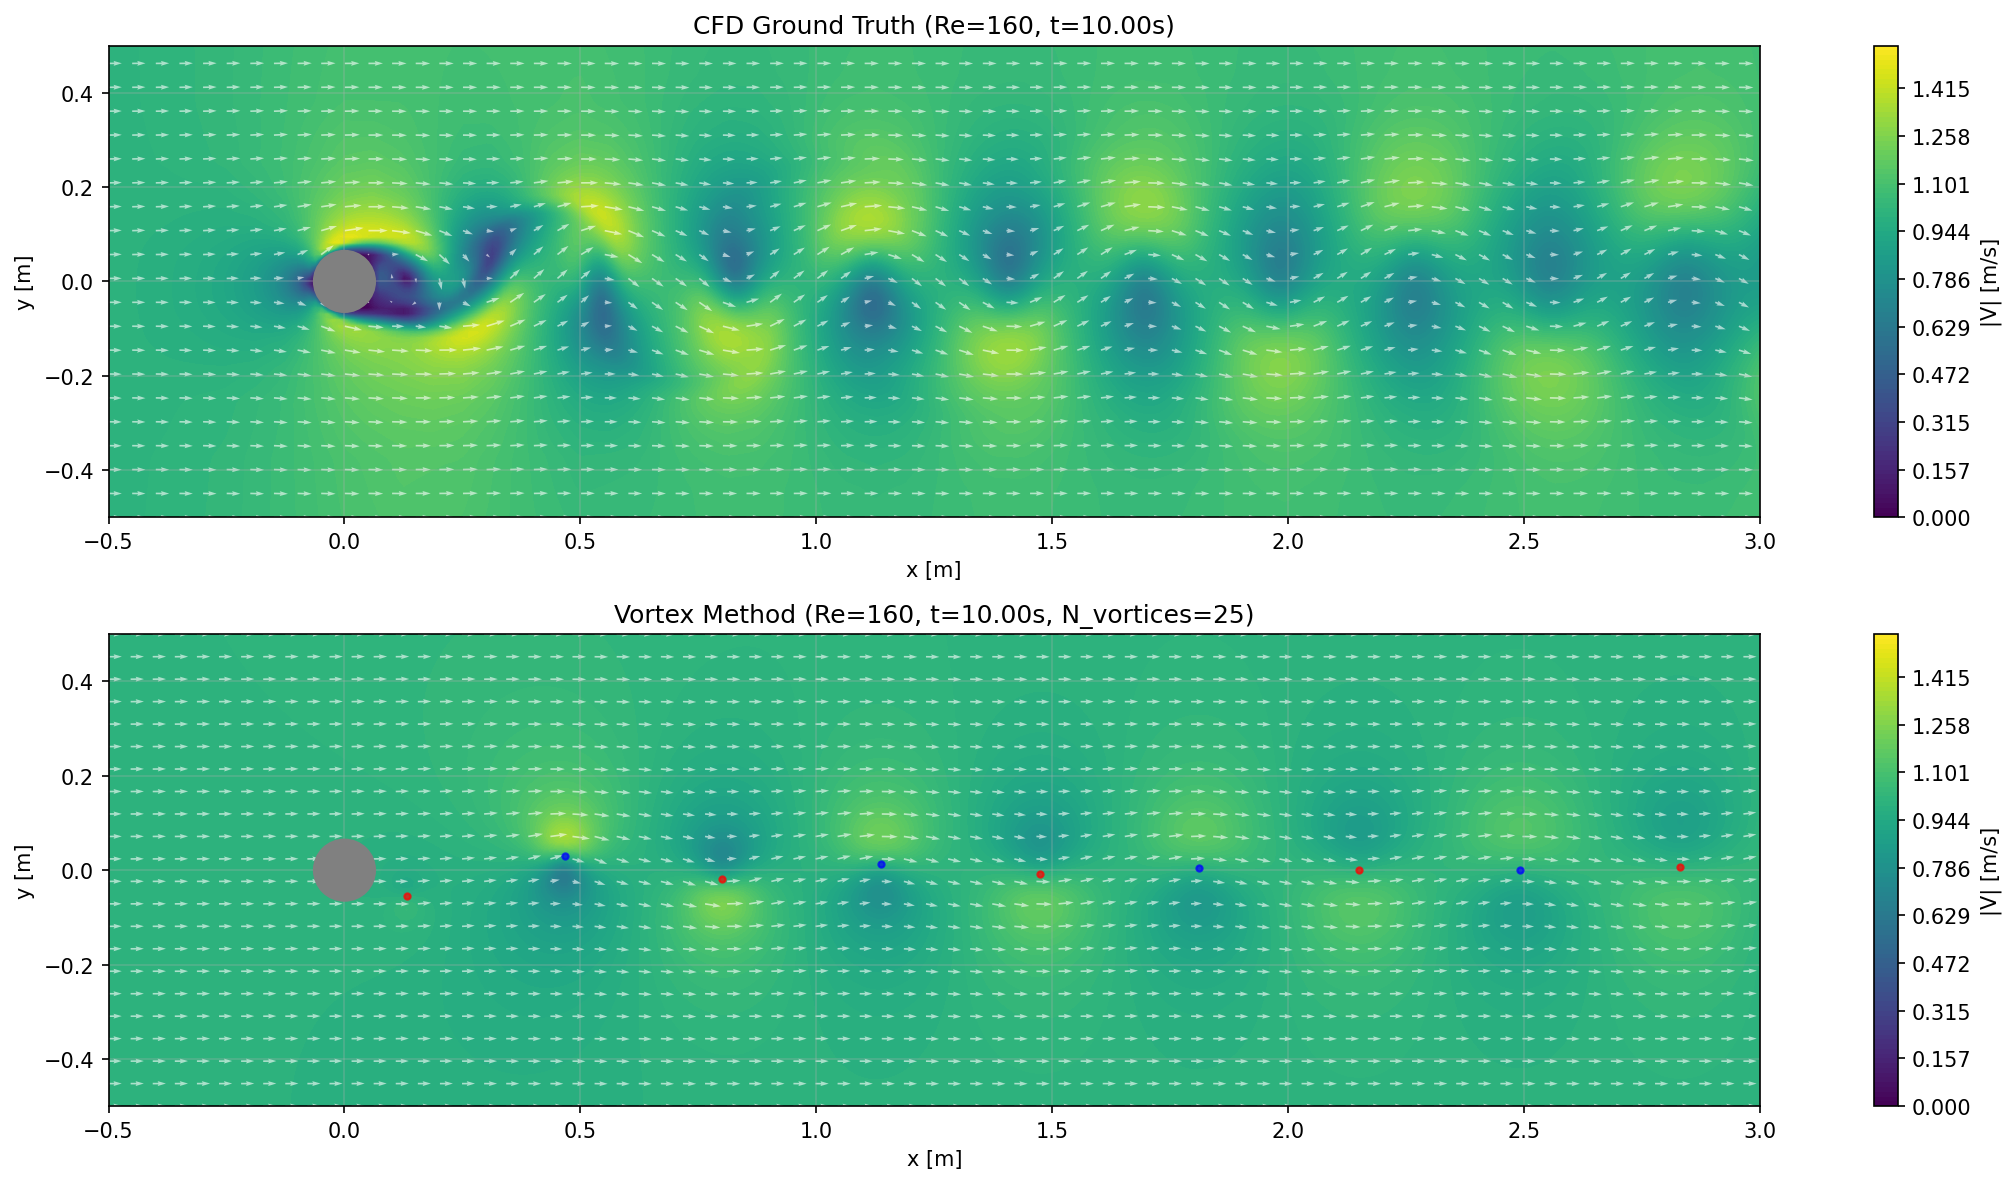

In [48]:
# Create side-by-side comparison figure
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Common colorbar limits
vmin = 0
vmax = max(cfd_vel_mag.max(), vm_vel_mag.max()) if vm_U is not None else cfd_vel_mag.max()

# --- CFD Ground Truth (top) ---
ax1 = axes[0]
contour1 = ax1.contourf(cfd_X, cfd_Y, cfd_vel_mag, levels=np.linspace(vmin, vmax, 100), cmap='viridis')
plt.colorbar(contour1, ax=ax1, label='|V| [m/s]')

skip = 4
ax1.quiver(cfd_X[::skip, ::skip], cfd_Y[::skip, ::skip],
           cfd_u[::skip, ::skip], cfd_v[::skip, ::skip],
           color='white', alpha=0.6, scale=vmax*80, width=0.001)

circle1 = Circle((0, 0), cfd_radius, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax1.add_patch(circle1)
ax1.set_xlim(X_MIN, 3.0)
ax1.set_ylim(Y_MIN, Y_MAX)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_title(f'CFD Ground Truth (Re={RE}, t={cfd_time:.2f}s)')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# --- Vortex Method (bottom) ---
ax2 = axes[1]
if vm_U is not None:
    contour2 = ax2.contourf(vm_X, vm_Y, vm_vel_mag, levels=np.linspace(vmin, vmax, 100), cmap='viridis')
    plt.colorbar(contour2, ax=ax2, label='|V| [m/s]')
    
    skip2 = 4
    ax2.quiver(vm_X[::skip2, ::skip2], vm_Y[::skip2, ::skip2],
               vm_U[::skip2, ::skip2], vm_V[::skip2, ::skip2],
               color='white', alpha=0.6, scale=vmax*80, width=0.001)
    
    # Plot vortex positions
    for v in vortices:
        color = 'red' if v['gamma'] > 0 else 'blue'
        ax2.plot(v['x'], v['y'], 'o', color=color, markersize=3, alpha=0.7)

circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax2.add_patch(circle2)
ax2.set_xlim(X_MIN, 3.0)
ax2.set_ylim(Y_MIN, Y_MAX)
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_title(f'Vortex Method (Re={RE}, t={vm_snapshot_time:.2f}s, N_vortices={len(vortices)})')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_velocity_comparison_nearwake.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\2883773099.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle1 = Circle((0, 0), cfd_radius, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\2883773099.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)


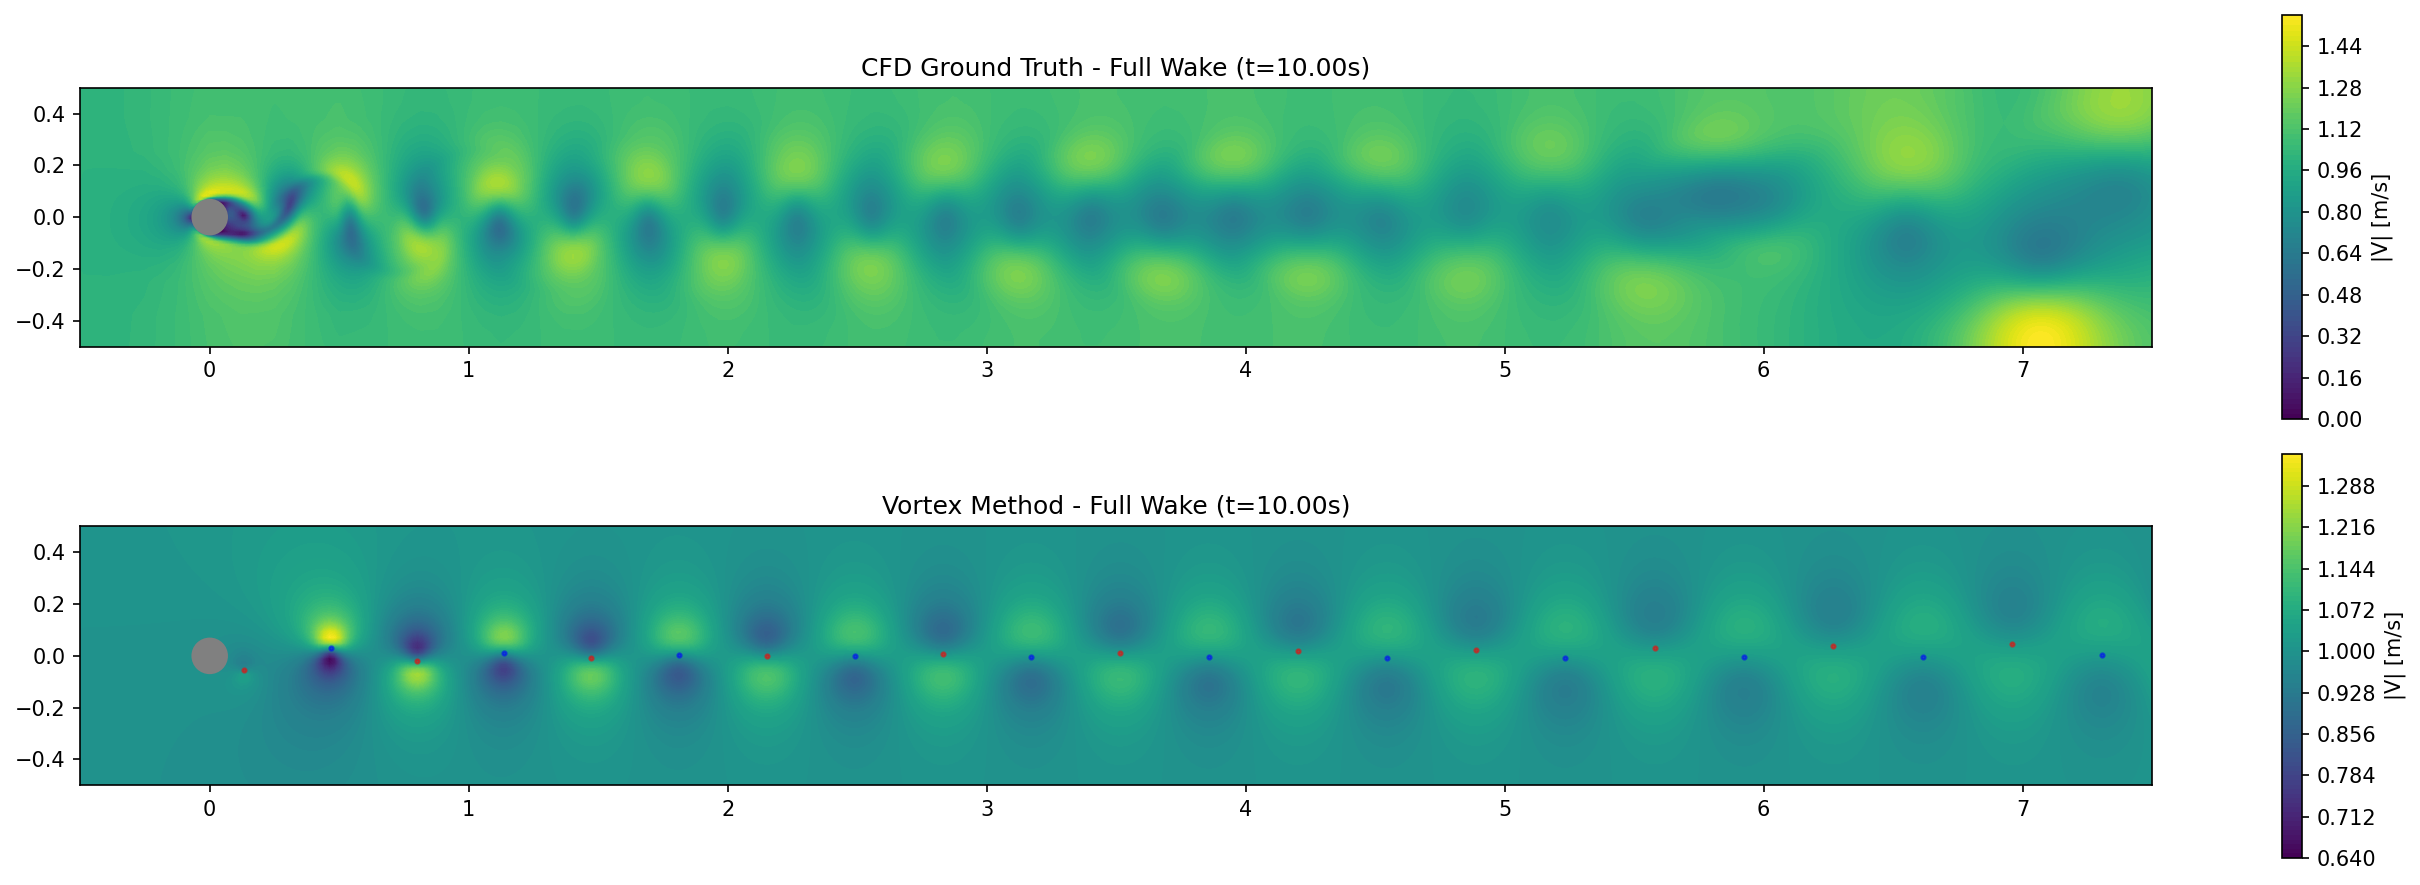

In [49]:
# Extended wake comparison (full CFD domain)
fig, axes = plt.subplots(2, 1, figsize=(18, 6))

# Compute VM field over full domain
vm_X_full, vm_Y_full, vm_U_full, vm_V_full, _ = compute_vm_velocity_on_grid(
    results, vm_snapshot_idx,
    x_range=(X_MIN, X_MAX),
    y_range=(Y_MIN, Y_MAX),
    grid_size=400
)

# CFD full domain
ax1 = axes[0]
contour1 = ax1.contourf(cfd_X, cfd_Y, cfd_vel_mag, levels=100, cmap='viridis')
plt.colorbar(contour1, ax=ax1, label='|V| [m/s]')
circle1 = Circle((0, 0), cfd_radius, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax1.add_patch(circle1)
ax1.set_xlim(X_MIN, X_MAX)
ax1.set_ylim(Y_MIN, Y_MAX)
ax1.set_title(f'CFD Ground Truth - Full Wake (t={cfd_time:.2f}s)')
ax1.set_aspect('equal')

# VM full domain  
ax2 = axes[1]
if vm_U_full is not None:
    vm_vel_mag_full = np.sqrt(vm_U_full**2 + vm_V_full**2)
    contour2 = ax2.contourf(vm_X_full, vm_Y_full, vm_vel_mag_full, levels=100, cmap='viridis')
    plt.colorbar(contour2, ax=ax2, label='|V| [m/s]')
    
    # Plot vortex positions
    for v in vortices:
        color = 'red' if v['gamma'] > 0 else 'blue'
        ax2.plot(v['x'], v['y'], 'o', color=color, markersize=2, alpha=0.5)

circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax2.add_patch(circle2)
ax2.set_xlim(X_MIN, X_MAX)
ax2.set_ylim(Y_MIN, Y_MAX)
ax2.set_title(f'Vortex Method - Full Wake (t={vm_snapshot_time:.2f}s)')
ax2.set_aspect('equal')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_velocity_comparison_fullwake.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# =============================================================================
# ERROR FIELD ANALYSIS
# =============================================================================
# Compute and visualize the error between CFD and Vortex Method

# Interpolate CFD data onto VM grid for direct comparison
from scipy.interpolate import RegularGridInterpolator

# Create interpolators for CFD velocity components
cfd_u_interp = RegularGridInterpolator((cfd_y, cfd_x), cfd_u, method='linear', bounds_error=False, fill_value=np.nan)
cfd_v_interp = RegularGridInterpolator((cfd_y, cfd_x), cfd_v, method='linear', bounds_error=False, fill_value=np.nan)

# Interpolate CFD onto VM grid
points = np.column_stack([vm_Y_full.ravel(), vm_X_full.ravel()])
cfd_u_on_vm = cfd_u_interp(points).reshape(vm_X_full.shape)
cfd_v_on_vm = cfd_v_interp(points).reshape(vm_X_full.shape)
cfd_mag_on_vm = np.sqrt(cfd_u_on_vm**2 + cfd_v_on_vm**2)

# Compute errors
error_u = vm_U_full - cfd_u_on_vm
error_v = vm_V_full - cfd_v_on_vm
error_mag = vm_vel_mag_full - cfd_mag_on_vm

# Relative error (avoid division by zero)
rel_error_mag = np.abs(error_mag) / np.maximum(cfd_mag_on_vm, 0.01) * 100

# Print error statistics
print("=" * 60)
print("ERROR STATISTICS")
print("=" * 60)
print(f"\nVelocity magnitude error:")
print(f"  Mean absolute error: {np.nanmean(np.abs(error_mag)):.4f} m/s")
print(f"  Max absolute error:  {np.nanmax(np.abs(error_mag)):.4f} m/s")
print(f"  RMS error:           {np.sqrt(np.nanmean(error_mag**2)):.4f} m/s")
print(f"  Mean relative error: {np.nanmean(rel_error_mag):.1f}%")
print(f"\nU-component error:")
print(f"  Mean absolute error: {np.nanmean(np.abs(error_u)):.4f} m/s")
print(f"  RMS error:           {np.sqrt(np.nanmean(error_u**2)):.4f} m/s")
print(f"\nV-component error:")
print(f"  Mean absolute error: {np.nanmean(np.abs(error_v)):.4f} m/s")
print(f"  RMS error:           {np.sqrt(np.nanmean(error_v**2)):.4f} m/s")
print("=" * 60)

ERROR STATISTICS

Velocity magnitude error:
  Mean absolute error: 0.1228 m/s
  Max absolute error:  0.9938 m/s
  RMS error:           0.1595 m/s
  Mean relative error: 25.7%

U-component error:
  Mean absolute error: 0.1292 m/s
  RMS error:           0.1707 m/s

V-component error:
  Mean absolute error: 0.1039 m/s
  RMS error:           0.1641 m/s


C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\2936810796.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle1 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\2936810796.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\2936810796.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle3 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)


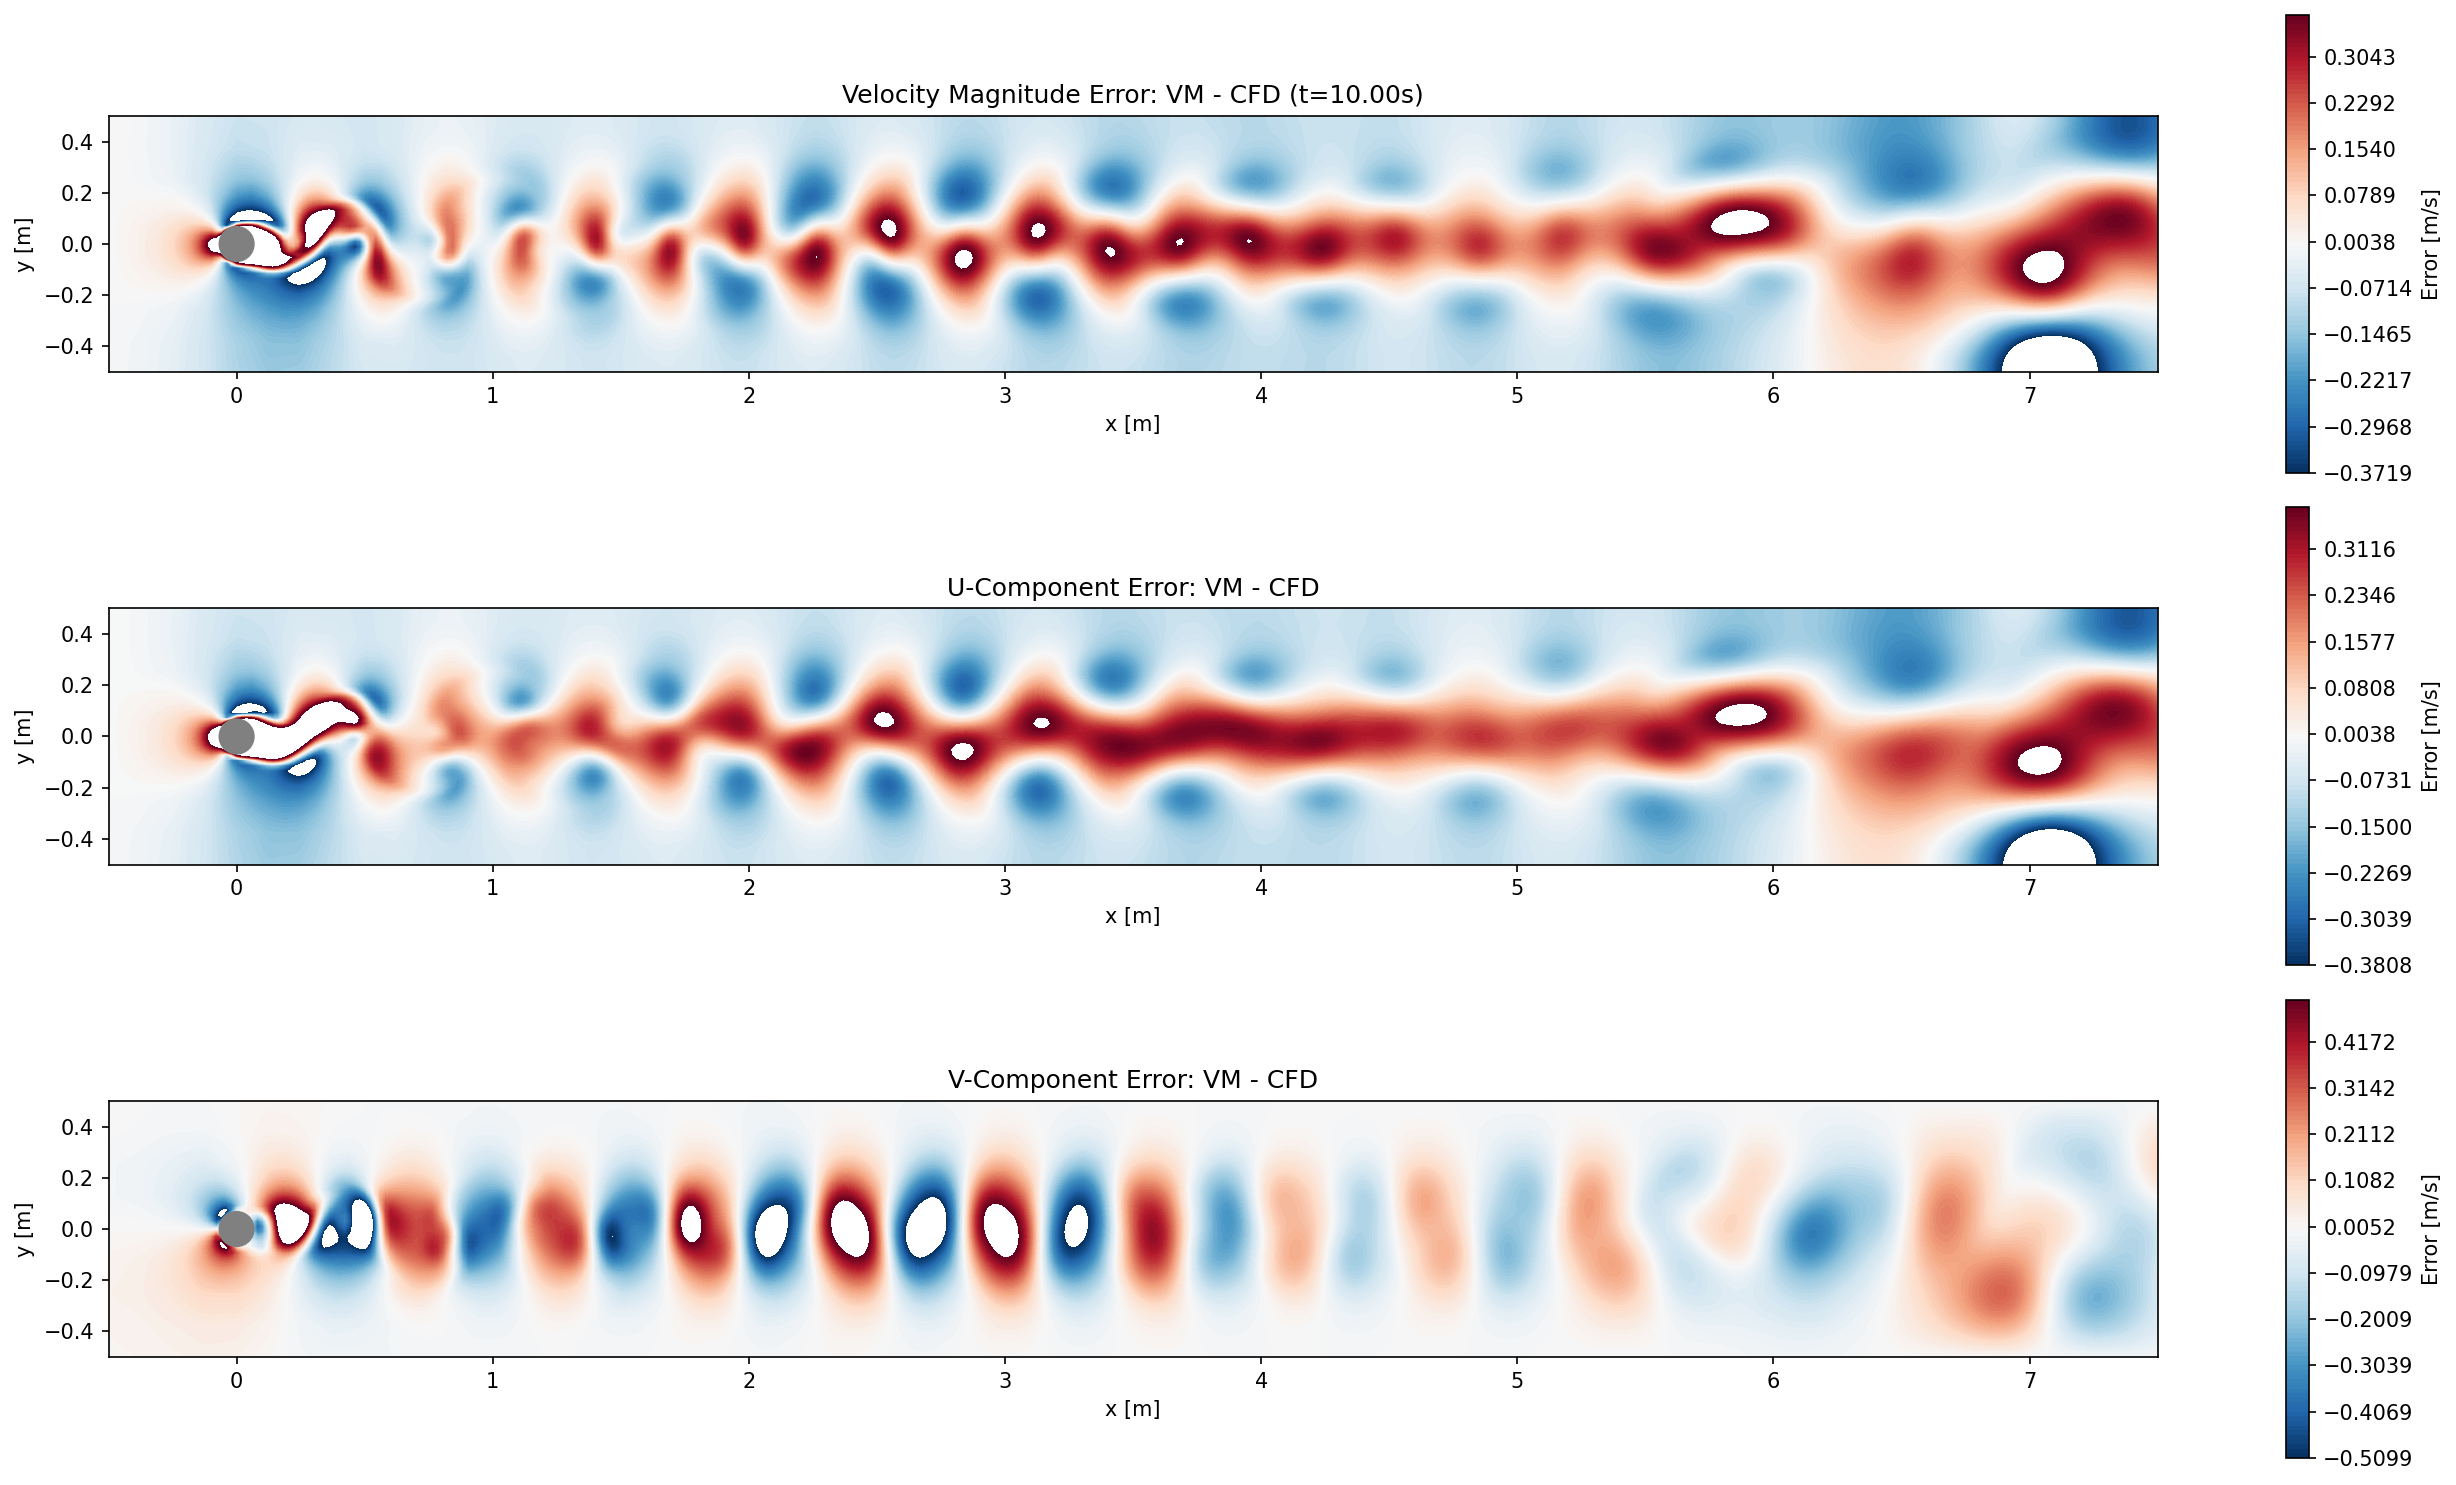

In [51]:
# Plot error fields
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

# Error in velocity magnitude
ax1 = axes[0]
err_max = np.nanpercentile(np.abs(error_mag), 98)
contour1 = ax1.contourf(vm_X_full, vm_Y_full, error_mag, 
                         levels=np.linspace(-err_max, err_max, 100), cmap='RdBu_r')
plt.colorbar(contour1, ax=ax1, label='Error [m/s]')
circle1 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax1.add_patch(circle1)
ax1.set_xlim(X_MIN, X_MAX)
ax1.set_ylim(Y_MIN, Y_MAX)
ax1.set_title(f'Velocity Magnitude Error: VM - CFD (t={cfd_time:.2f}s)')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_aspect('equal')

# Error in u-component
ax2 = axes[1]
err_u_max = np.nanpercentile(np.abs(error_u), 98)
contour2 = ax2.contourf(vm_X_full, vm_Y_full, error_u, 
                         levels=np.linspace(-err_u_max, err_u_max, 100), cmap='RdBu_r')
plt.colorbar(contour2, ax=ax2, label='Error [m/s]')
circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax2.add_patch(circle2)
ax2.set_xlim(X_MIN, X_MAX)
ax2.set_ylim(Y_MIN, Y_MAX)
ax2.set_title(f'U-Component Error: VM - CFD')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_aspect('equal')

# Error in v-component
ax3 = axes[2]
err_v_max = np.nanpercentile(np.abs(error_v), 98)
contour3 = ax3.contourf(vm_X_full, vm_Y_full, error_v, 
                         levels=np.linspace(-err_v_max, err_v_max, 100), cmap='RdBu_r')
plt.colorbar(contour3, ax=ax3, label='Error [m/s]')
circle3 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax3.add_patch(circle3)
ax3.set_xlim(X_MIN, X_MAX)
ax3.set_ylim(Y_MIN, Y_MAX)
ax3.set_title(f'V-Component Error: VM - CFD')
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_aspect('equal')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_error_fields.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 5b. Probe Time Series Comparison (CFD vs Vortex Method)

Compare velocity time series at probe locations between CFD ground truth and vortex method.

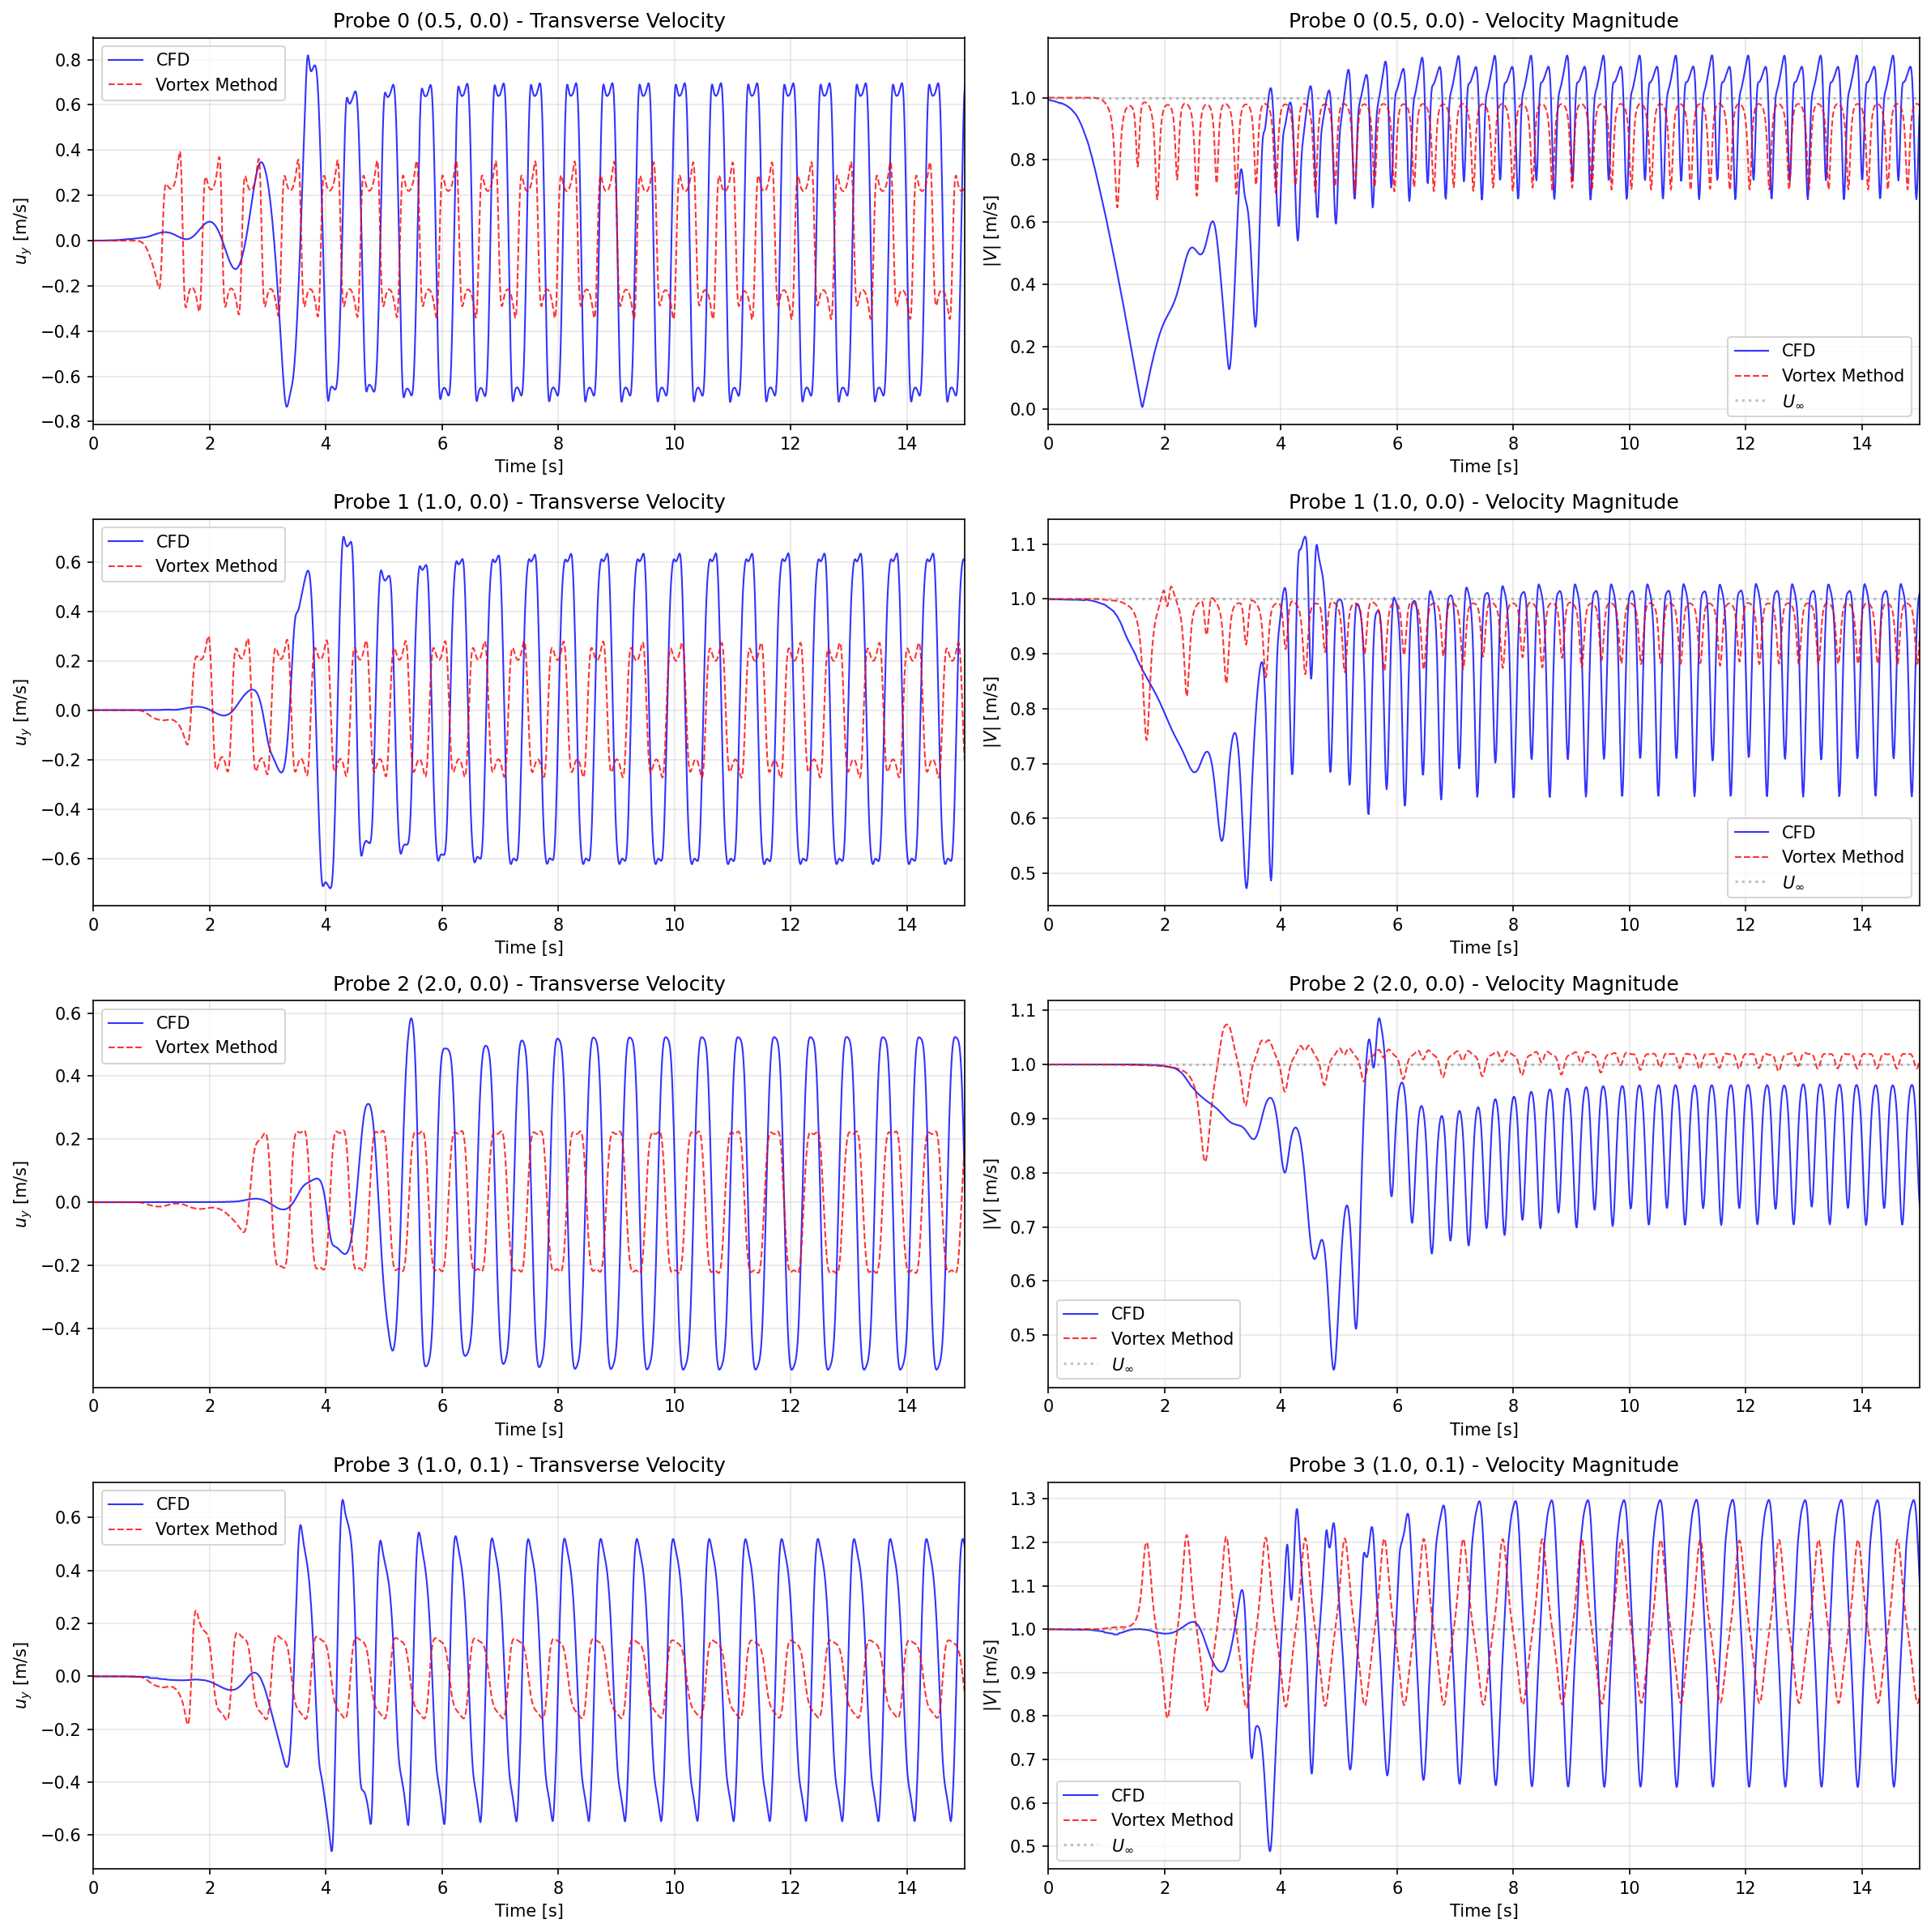

In [52]:
# =============================================================================
# PROBE TIME SERIES COMPARISON: CFD vs VORTEX METHOD
# =============================================================================

# Interpolate VM results onto CFD time points for fair comparison
from scipy.interpolate import interp1d

vm_time = results['time'].values
cfd_time_arr = cfd_probe_data['cfd_time']

# Plot comparison for each probe
fig, axes = plt.subplots(len(measurement_points), 2, figsize=(16, 4*len(measurement_points)))

for i, (px, py) in enumerate(measurement_points):
    # Get CFD data
    cfd_uy = cfd_probe_data[f'cfd_probe_{i}_uy']
    cfd_vmag = cfd_probe_data[f'cfd_probe_{i}_vmag']
    
    # Get VM data
    vm_uy = results[f'probe_{i}_uy'].values
    vm_vmag = results[f'probe_{i}_vmag'].values
    
    # Interpolate VM onto CFD time grid (CFD has longer time range)
    # Only compare over the overlapping time range
    t_max_common = min(vm_time.max(), cfd_time_arr.max())
    t_min_common = max(vm_time.min(), cfd_time_arr.min())
    
    # Create interpolators for VM data
    vm_uy_interp = interp1d(vm_time, vm_uy, kind='linear', bounds_error=False, fill_value=np.nan)
    vm_vmag_interp = interp1d(vm_time, vm_vmag, kind='linear', bounds_error=False, fill_value=np.nan)
    
    # Time mask for common range
    cfd_mask = (cfd_time_arr >= t_min_common) & (cfd_time_arr <= t_max_common)
    t_common = cfd_time_arr[cfd_mask]
    
    # Plot v-component (shows shedding oscillation)
    ax1 = axes[i, 0] if len(measurement_points) > 1 else axes[0]
    ax1.plot(cfd_time_arr, cfd_uy, 'b-', linewidth=1, label='CFD', alpha=0.8)
    ax1.plot(vm_time, vm_uy, 'r--', linewidth=1, label='Vortex Method', alpha=0.8)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('$u_y$ [m/s]')
    ax1.set_title(f'Probe {i} ({px}, {py}) - Transverse Velocity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, t_max_common)
    
    # Plot velocity magnitude
    ax2 = axes[i, 1] if len(measurement_points) > 1 else axes[1]
    ax2.plot(cfd_time_arr, cfd_vmag, 'b-', linewidth=1, label='CFD', alpha=0.8)
    ax2.plot(vm_time, vm_vmag, 'r--', linewidth=1, label='Vortex Method', alpha=0.8)
    ax2.axhline(U_INF, color='gray', linestyle=':', alpha=0.5, label='$U_\\infty$')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('$|V|$ [m/s]')
    ax2.set_title(f'Probe {i} ({px}, {py}) - Velocity Magnitude')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, t_max_common)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_probe_comparison_cfd_vs_vm.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# =============================================================================
# STROUHAL NUMBER COMPARISON: CFD vs VORTEX METHOD
# =============================================================================

# Analyze shedding frequency from both CFD and VM probe data
probe_idx = 1  # Mid-wake centerline probe

# Skip initial transient
t_transient = 3.0  # seconds

# --- CFD Strouhal ---
cfd_dt = cfd_time_arr[1] - cfd_time_arr[0]
cfd_idx_start = np.argmin(np.abs(cfd_time_arr - t_transient))
cfd_uy_signal = cfd_probe_data[f'cfd_probe_{probe_idx}_uy'][cfd_idx_start:]

cfd_frequencies, cfd_psd = signal.welch(cfd_uy_signal, fs=1/cfd_dt, nperseg=min(512, len(cfd_uy_signal)//2))
cfd_idx_peak = np.argmax(cfd_psd)
cfd_f_measured = cfd_frequencies[cfd_idx_peak]
cfd_St_measured = cfd_f_measured * CYLINDER_DIAMETER / U_INF

# --- VM Strouhal ---
vm_dt = vm_time[1] - vm_time[0]
vm_idx_start = np.argmin(np.abs(vm_time - t_transient))
vm_uy_signal = results[f'probe_{probe_idx}_uy'].values[vm_idx_start:]

vm_frequencies, vm_psd = signal.welch(vm_uy_signal, fs=1/vm_dt, nperseg=min(512, len(vm_uy_signal)//2))
vm_idx_peak = np.argmax(vm_psd)
vm_f_measured = vm_frequencies[vm_idx_peak]
vm_St_measured = vm_f_measured * CYLINDER_DIAMETER / U_INF

print("=" * 70)
print("STROUHAL NUMBER COMPARISON")
print("=" * 70)
print(f"\nTheoretical (Roshko correlation for Re={RE}):")
print(f"  St = {ST_THEORETICAL:.4f}")
print(f"  f  = {ST_THEORETICAL * U_INF / CYLINDER_DIAMETER:.4f} Hz")
print(f"\nCFD Ground Truth (probe {probe_idx}):")
print(f"  St = {cfd_St_measured:.4f}")
print(f"  f  = {cfd_f_measured:.4f} Hz")
print(f"  Error vs theory: {abs(cfd_St_measured - ST_THEORETICAL)/ST_THEORETICAL * 100:.1f}%")
print(f"\nVortex Method (probe {probe_idx}):")
print(f"  St = {vm_St_measured:.4f}")
print(f"  f  = {vm_f_measured:.4f} Hz")
print(f"  Error vs theory: {abs(vm_St_measured - ST_THEORETICAL)/ST_THEORETICAL * 100:.1f}%")
print(f"  Error vs CFD:    {abs(vm_St_measured - cfd_St_measured)/cfd_St_measured * 100:.1f}%")
print("=" * 70)

STROUHAL NUMBER COMPARISON

Theoretical (Roshko correlation for Re=160):
  St = 0.1839
  f  = 1.4713 Hz

CFD Ground Truth (probe 1):
  St = 0.1953
  f  = 1.5625 Hz
  Error vs theory: 6.2%

Vortex Method (probe 1):
  St = 0.1953
  f  = 1.5625 Hz
  Error vs theory: 6.2%
  Error vs CFD:    0.0%


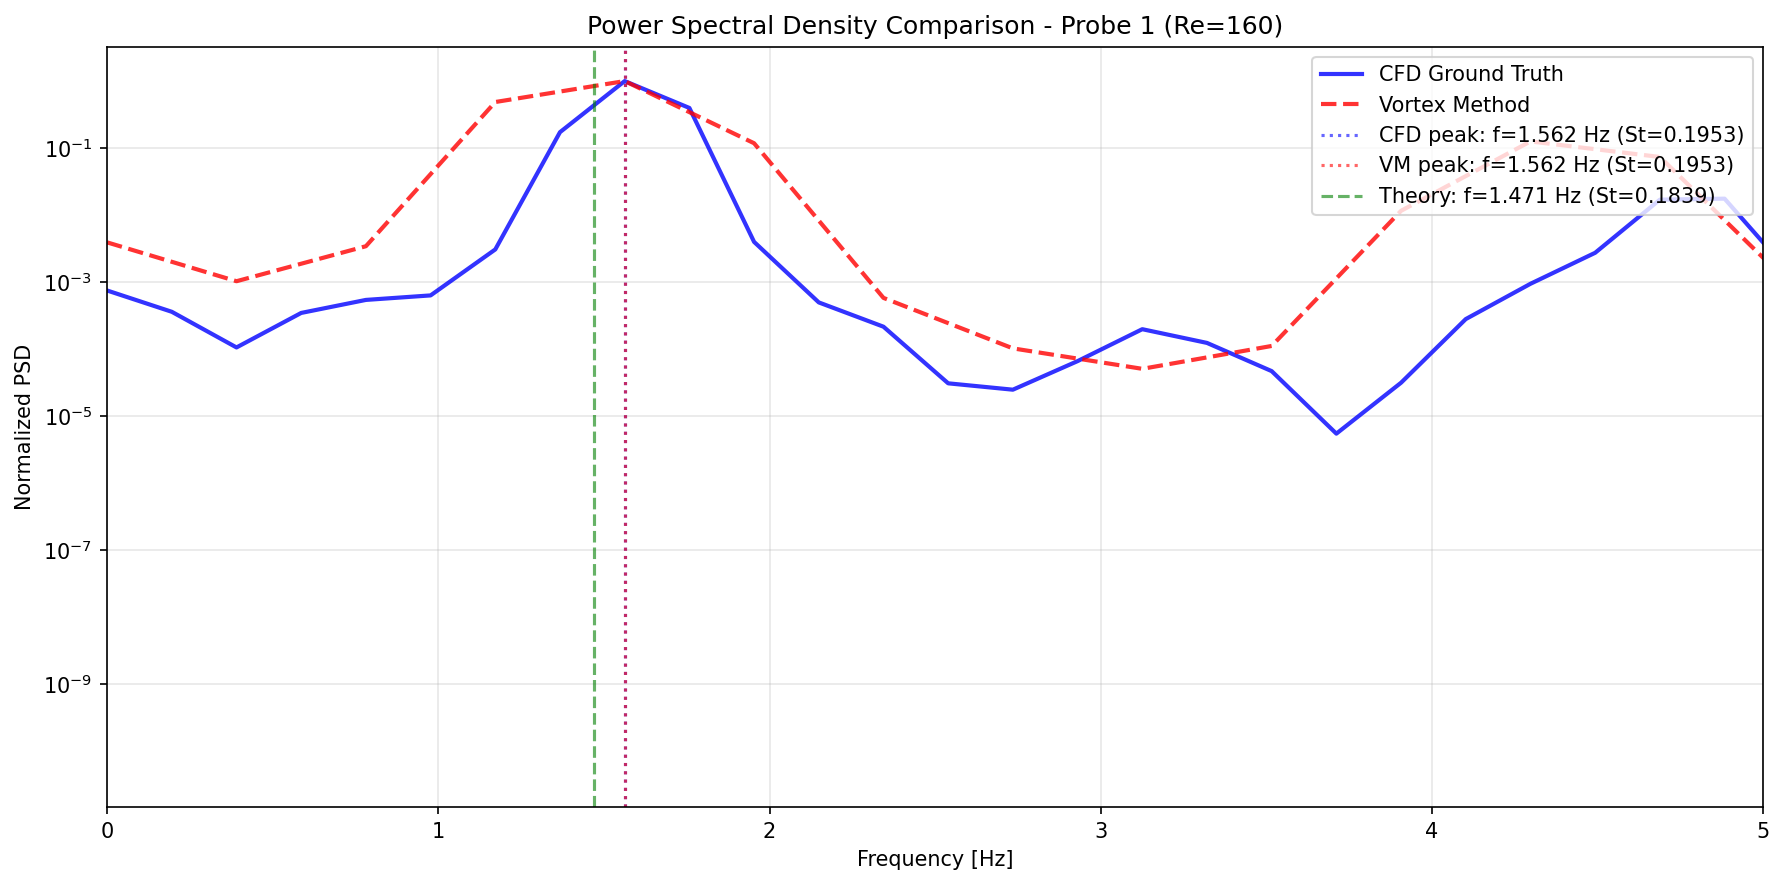

In [54]:
# Plot PSD comparison: CFD vs Vortex Method
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize PSDs for comparison
cfd_psd_norm = cfd_psd / cfd_psd.max()
vm_psd_norm = vm_psd / vm_psd.max()

ax.semilogy(cfd_frequencies, cfd_psd_norm, 'b-', linewidth=2, label='CFD Ground Truth', alpha=0.8)
ax.semilogy(vm_frequencies, vm_psd_norm, 'r--', linewidth=2, label='Vortex Method', alpha=0.8)

# Mark peaks
ax.axvline(cfd_f_measured, color='b', linestyle=':', alpha=0.6, 
           label=f'CFD peak: f={cfd_f_measured:.3f} Hz (St={cfd_St_measured:.4f})')
ax.axvline(vm_f_measured, color='r', linestyle=':', alpha=0.6,
           label=f'VM peak: f={vm_f_measured:.3f} Hz (St={vm_St_measured:.4f})')
ax.axvline(ST_THEORETICAL * U_INF / CYLINDER_DIAMETER, color='green', linestyle='--', alpha=0.6,
           label=f'Theory: f={ST_THEORETICAL * U_INF / CYLINDER_DIAMETER:.3f} Hz (St={ST_THEORETICAL:.4f})')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Normalized PSD')
ax.set_title(f'Power Spectral Density Comparison - Probe {probe_idx} (Re={RE})')
ax.set_xlim(0, 5)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/06_strouhal_comparison_psd.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6. Quantitative Analysis

Compare shedding frequency, Strouhal number, and velocity statistics.

In [55]:
# Strouhal number analysis from vortex method probe data
time_arr = results['time'].values
dt = time_arr[1] - time_arr[0]

# Skip initial transient (first 20% of simulation)
t_start = TOTAL_TIME * 0.2
idx_start = np.argmin(np.abs(time_arr - t_start))

# Analyze probe 1 (mid-wake, centerline)
probe_idx = 1
uy_signal = results[f'probe_{probe_idx}_uy'].values[idx_start:]

# Compute power spectral density
frequencies, psd = signal.welch(uy_signal, fs=1/dt, nperseg=min(1024, len(uy_signal)//4))

# Find dominant frequency
idx_peak = np.argmax(psd)
f_measured = frequencies[idx_peak]
St_measured = f_measured * CYLINDER_DIAMETER / U_INF

print("=" * 60)
print("STROUHAL NUMBER ANALYSIS")
print("=" * 60)
print(f"\nTheoretical (Roshko correlation for Re={RE}):")
print(f"  St = {ST_THEORETICAL:.4f}")
print(f"  f  = {ST_THEORETICAL * U_INF / CYLINDER_DIAMETER:.4f} Hz")
print(f"\nMeasured from vortex method (probe {probe_idx}):")
print(f"  St = {St_measured:.4f}")
print(f"  f  = {f_measured:.4f} Hz")
print(f"\nRelative error: {abs(St_measured - ST_THEORETICAL)/ST_THEORETICAL * 100:.1f}%")
print("=" * 60)

STROUHAL NUMBER ANALYSIS

Theoretical (Roshko correlation for Re=160):
  St = 0.1839
  f  = 1.4713 Hz

Measured from vortex method (probe 1):
  St = 0.1667
  f  = 1.3333 Hz

Relative error: 9.4%


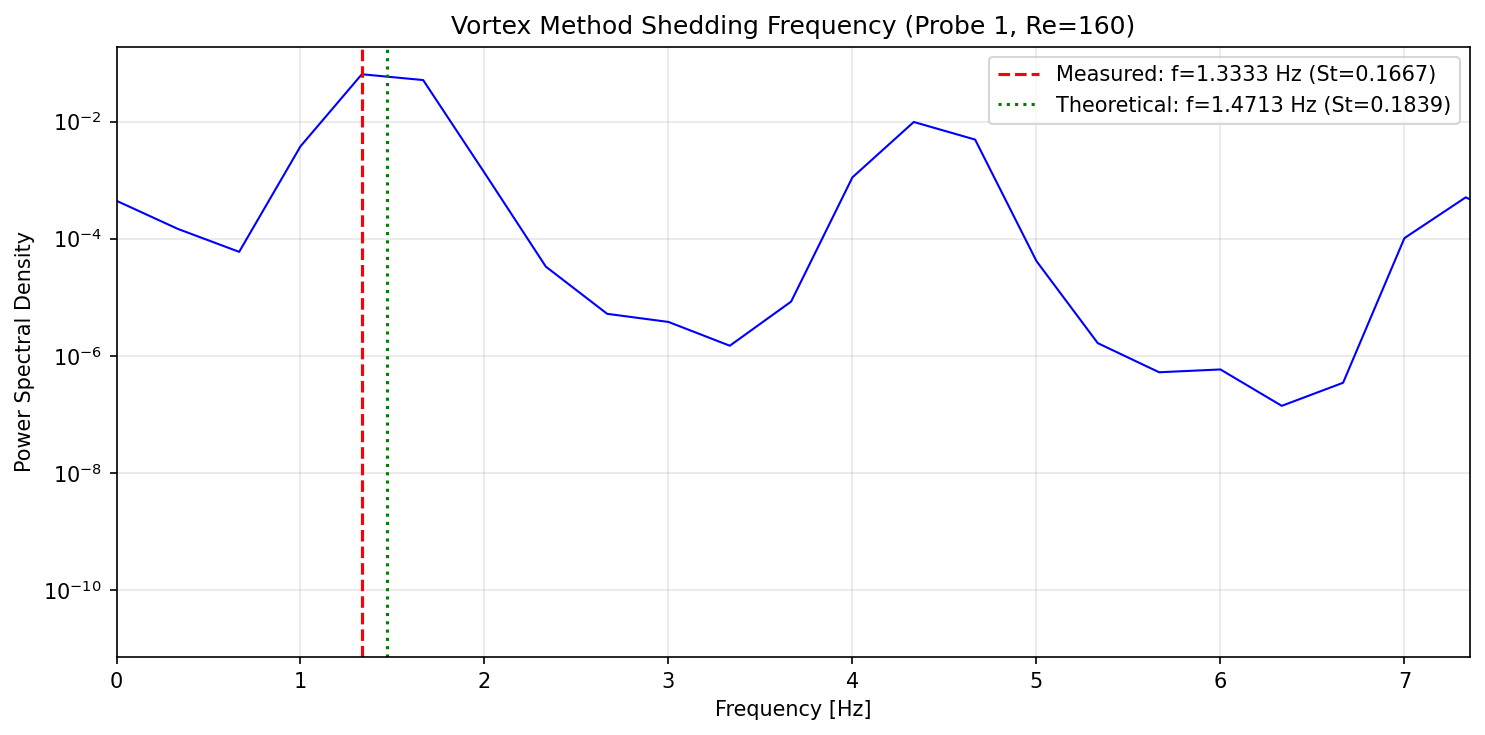

In [56]:
# Plot power spectral density (VM only - detailed view)
fig, ax = plt.subplots(figsize=(10, 5))

ax.semilogy(frequencies, psd, 'b-', linewidth=1)
ax.axvline(f_measured, color='r', linestyle='--', label=f'Measured: f={f_measured:.4f} Hz (St={St_measured:.4f})')
ax.axvline(ST_THEORETICAL * U_INF / CYLINDER_DIAMETER, color='g', linestyle=':', 
           label=f'Theoretical: f={ST_THEORETICAL * U_INF / CYLINDER_DIAMETER:.4f} Hz (St={ST_THEORETICAL:.4f})')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density')
ax.set_title(f'Vortex Method Shedding Frequency (Probe {probe_idx}, Re={RE})')
ax.set_xlim(0, 5 * ST_THEORETICAL * U_INF / CYLINDER_DIAMETER)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/07_vm_strouhal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

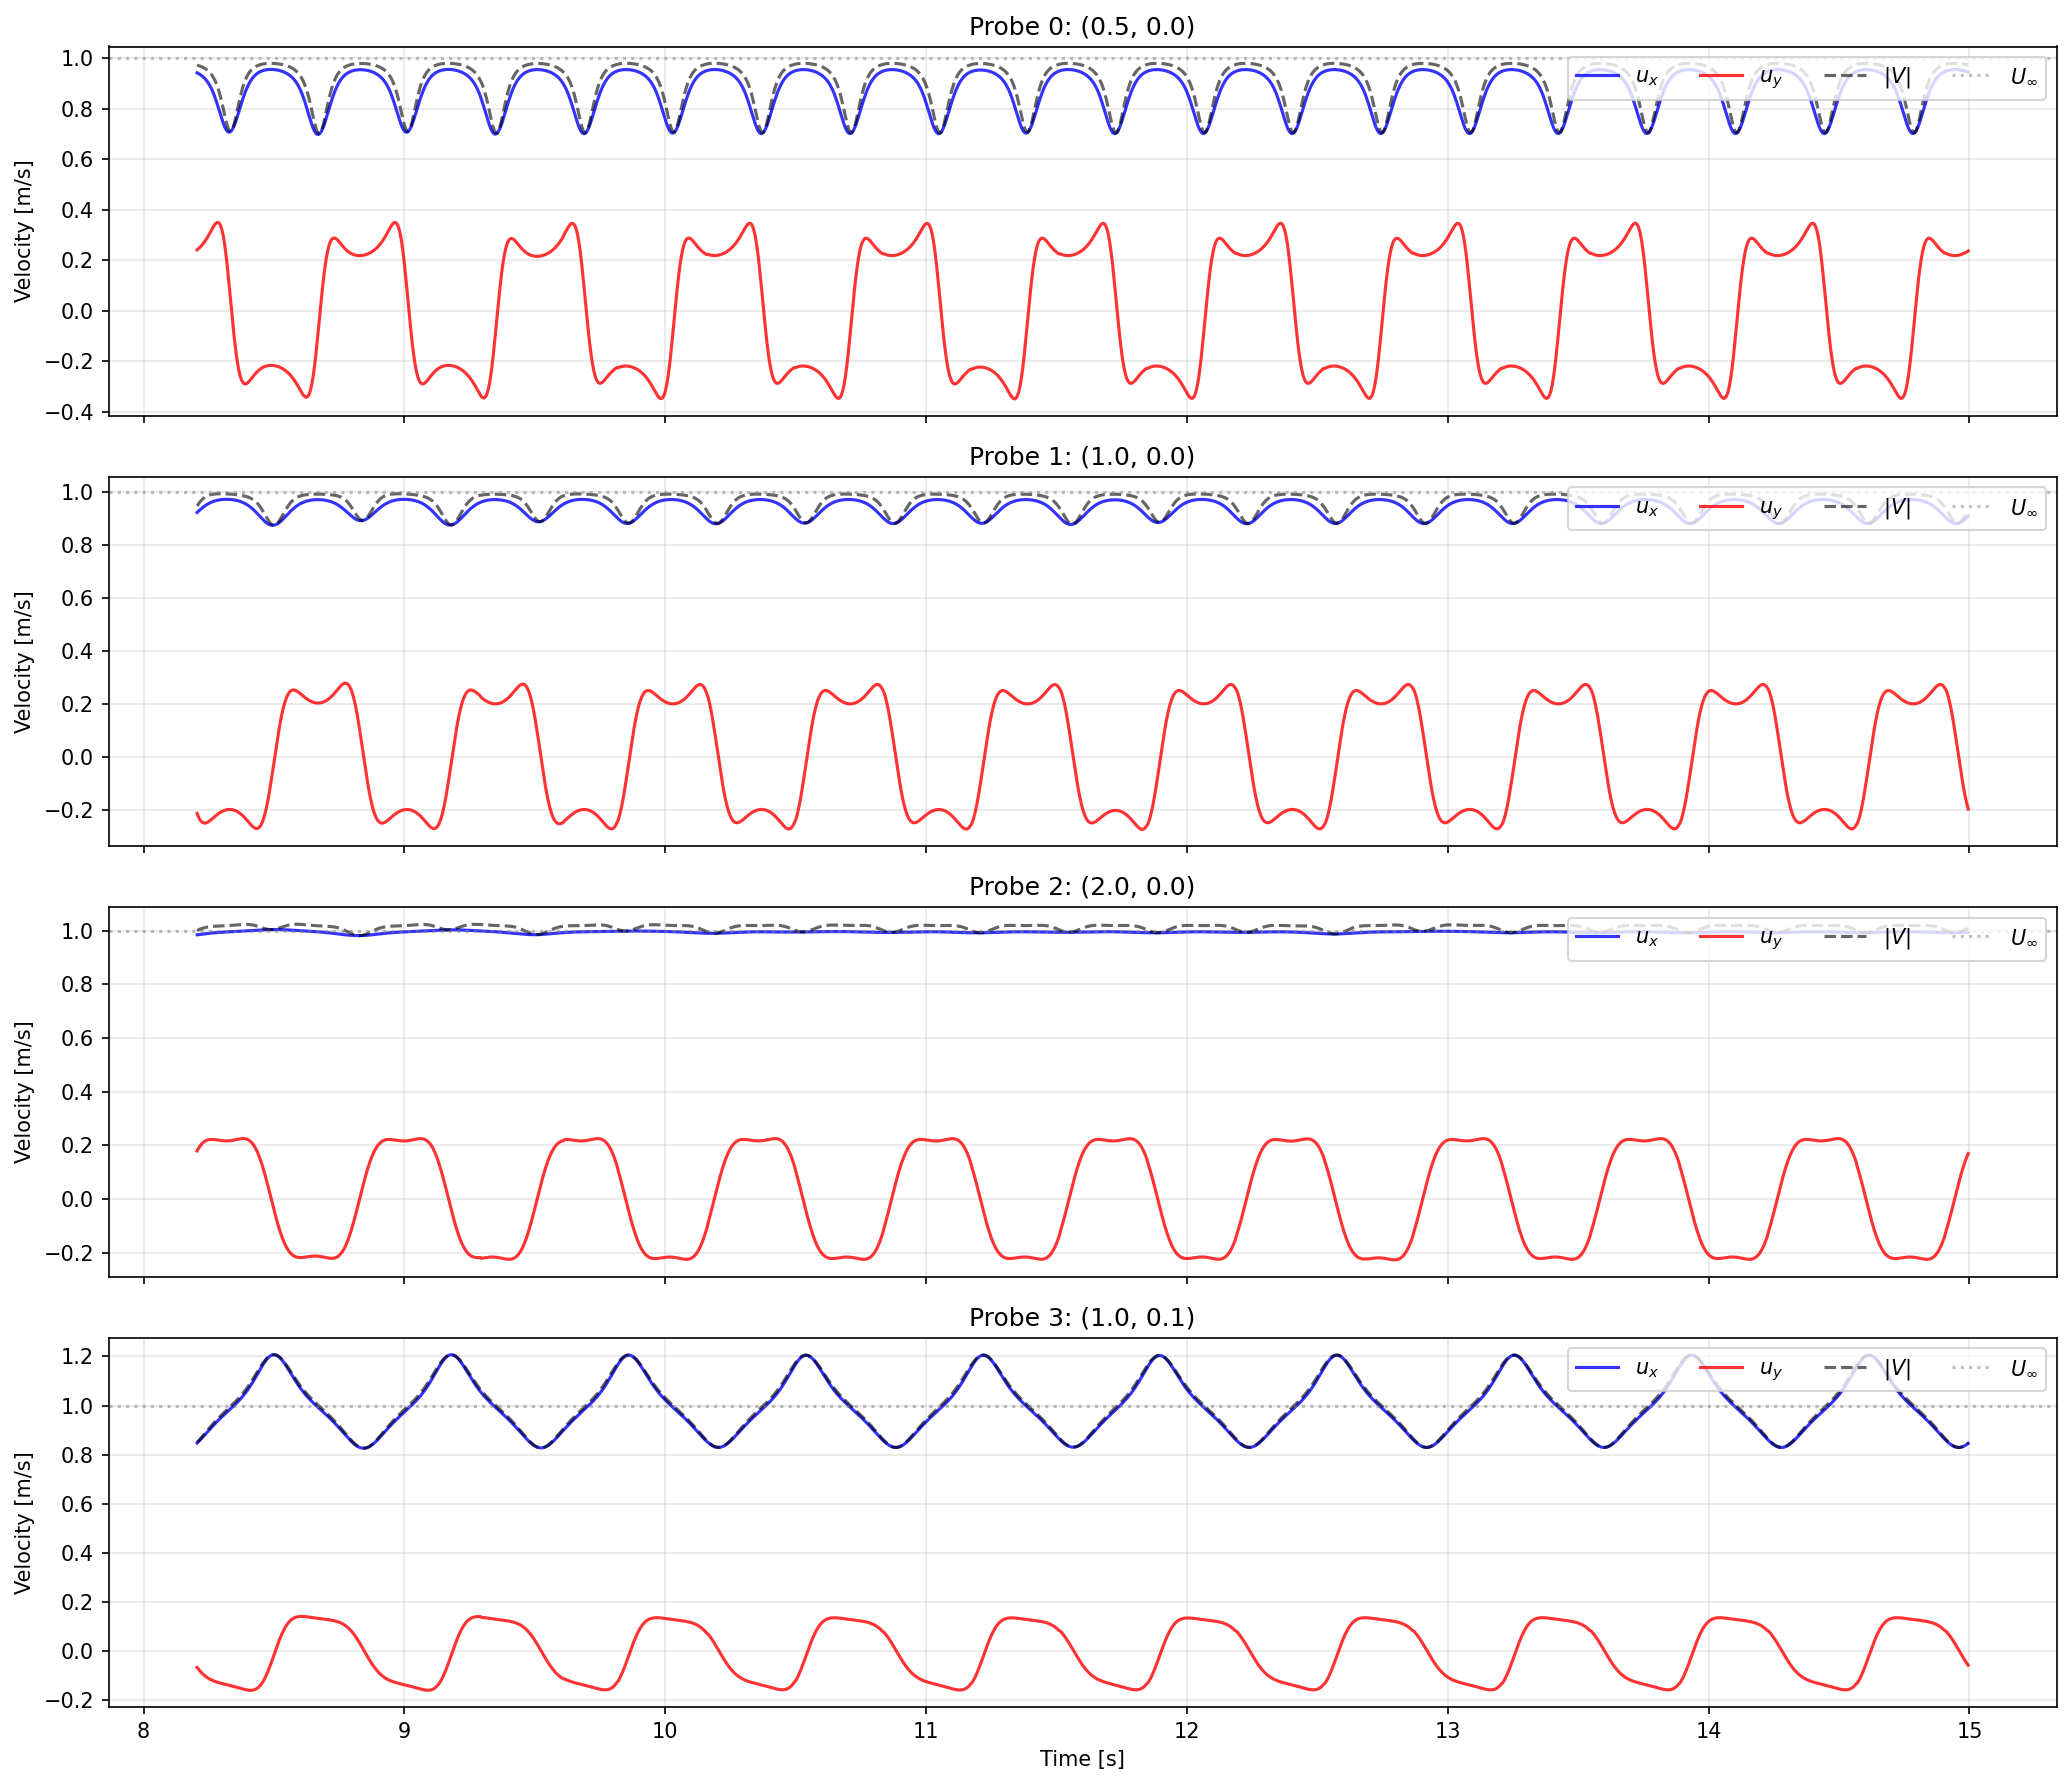

In [57]:
# Plot velocity time series at measurement probes (VM only)
fig, axes = plt.subplots(len(measurement_points), 1, figsize=(14, 3*len(measurement_points)), sharex=True)

# Plot window (last few shedding cycles)
T_shedding = CYLINDER_DIAMETER / (ST_THEORETICAL * U_INF)
t_plot_start = max(t_start, TOTAL_TIME - 10 * T_shedding)
t_plot_end = TOTAL_TIME

time_arr = results['time'].values
mask = (time_arr >= t_plot_start) & (time_arr <= t_plot_end)

for i, (px, py) in enumerate(measurement_points):
    ax = axes[i] if len(measurement_points) > 1 else axes
    
    ux = results[f'probe_{i}_ux'].values[mask]
    uy = results[f'probe_{i}_uy'].values[mask]
    vmag = results[f'probe_{i}_vmag'].values[mask]
    t_plot = time_arr[mask]
    
    ax.plot(t_plot, ux, 'b-', label='$u_x$', alpha=0.8)
    ax.plot(t_plot, uy, 'r-', label='$u_y$', alpha=0.8)
    ax.plot(t_plot, vmag, 'k--', label='$|V|$', alpha=0.6)
    ax.axhline(U_INF, color='gray', linestyle=':', alpha=0.5, label='$U_\\infty$')
    
    ax.set_ylabel('Velocity [m/s]')
    ax.set_title(f'Probe {i}: ({px}, {py})')
    ax.legend(loc='upper right', ncol=4)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/08_vm_velocity_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# =============================================================================
# FINAL VALIDATION SUMMARY
# =============================================================================

print("\n" + "=" * 70)
print("VALIDATION SUMMARY")
print("=" * 70)

print(f"\n--- SIMULATION PARAMETERS ---")
print(f"  Reynolds number:        Re = {RE}")
print(f"  Cylinder diameter:      D  = {CYLINDER_DIAMETER} m")
print(f"  Freestream velocity:    U  = {U_INF} m/s")
print(f"  Kinematic viscosity:    nu = {NU} m^2/s")
print(f"  Simulation time:        T  = {TOTAL_TIME} s")

print(f"\n--- STROUHAL NUMBER COMPARISON ---")
print(f"  Theoretical (Roshko):   St = {ST_THEORETICAL:.4f}")
print(f"  CFD Ground Truth:       St = {cfd_St_measured:.4f}  (error vs theory: {abs(cfd_St_measured - ST_THEORETICAL)/ST_THEORETICAL * 100:.1f}%)")
print(f"  Vortex Method:          St = {vm_St_measured:.4f}  (error vs theory: {abs(vm_St_measured - ST_THEORETICAL)/ST_THEORETICAL * 100:.1f}%)")
print(f"  VM vs CFD error:        {abs(vm_St_measured - cfd_St_measured)/cfd_St_measured * 100:.1f}%")

print(f"\n--- VELOCITY FIELD ERROR (at t={cfd_time:.2f}s) ---")
print(f"  Mean absolute error:    {np.nanmean(np.abs(error_mag)):.4f} m/s")
print(f"  RMS error:              {np.sqrt(np.nanmean(error_mag**2)):.4f} m/s")
print(f"  Mean relative error:    {np.nanmean(rel_error_mag):.1f}%")

print(f"\n--- VORTEX STATISTICS ---")
print(f"  Number of vortices:     {len(vortices)}")
if vortices:
    gammas = [v['gamma'] for v in vortices]
    sigmas = [v['sigma'] for v in vortices]
    print(f"  Circulation range:      [{min(gammas):.4f}, {max(gammas):.4f}] m^2/s")
    print(f"  Core size range:        [{min(sigmas):.4f}, {max(sigmas):.4f}] m")

print(f"\n--- OUTPUT FILES ---")
print(f"  Directory: {os.path.abspath(OUTPUT_DIR)}")
print(f"  01_cfd_ground_truth.png")
print(f"  02_velocity_comparison_nearwake.png")
print(f"  03_velocity_comparison_fullwake.png")
print(f"  04_error_fields.png")
print(f"  05_probe_comparison_cfd_vs_vm.png")
print(f"  06_strouhal_comparison_psd.png")
print(f"  07_vm_strouhal_analysis.png")
print(f"  08_vm_velocity_timeseries.png")
print(f"  validation_results.pkl")

print("=" * 70)


VALIDATION SUMMARY

--- SIMULATION PARAMETERS ---
  Reynolds number:        Re = 160
  Cylinder diameter:      D  = 0.125 m
  Freestream velocity:    U  = 1.0 m/s
  Kinematic viscosity:    nu = 0.00078125 m^2/s
  Simulation time:        T  = 15.0 s

--- STROUHAL NUMBER COMPARISON ---
  Theoretical (Roshko):   St = 0.1839
  CFD Ground Truth:       St = 0.1953  (error vs theory: 6.2%)
  Vortex Method:          St = 0.1953  (error vs theory: 6.2%)
  VM vs CFD error:        0.0%

--- VELOCITY FIELD ERROR (at t=10.00s) ---
  Mean absolute error:    0.1228 m/s
  RMS error:              0.1595 m/s
  Mean relative error:    25.7%

--- VORTEX STATISTICS ---
  Number of vortices:     25
  Circulation range:      [-0.1444, 0.1444] m^2/s
  Core size range:        [0.0244, 0.1615] m

--- OUTPUT FILES ---
  Directory: c:\Projects\von-karman\output\validation
  01_cfd_ground_truth.png
  02_velocity_comparison_nearwake.png
  03_velocity_comparison_fullwake.png
  04_error_fields.png
  05_probe_compari

---
## 7. Vorticity Strength Comparison

Compare vorticity magnitudes between CFD ground truth and VortexAmp to verify circulation approximation.

In [59]:
# =============================================================================
# VORTICITY STRENGTH COMPARISON: CFD vs VortexAmp
# =============================================================================

from scipy.ndimage import maximum_filter, minimum_filter, label

# Get CFD velocity data at t=10s
cfd_u_t10 = ds.variables['u'][CFD_TIMESTEP, :, :]
cfd_v_t10 = ds.variables['v'][CFD_TIMESTEP, :, :]

# Grid spacing
dx_cfd = cfd_x[1] - cfd_x[0]
dy_cfd = cfd_y[1] - cfd_y[0]

# Compute vorticity: omega = dv/dx - du/dy
dvdx = np.gradient(cfd_v_t10, dx_cfd, axis=1)
dudy = np.gradient(cfd_u_t10, dy_cfd, axis=0)
cfd_vorticity = dvdx - dudy

print("=" * 70)
print("VORTICITY FIELD STATISTICS (CFD Ground Truth)")
print("=" * 70)
print(f"\nGrid spacing: dx={dx_cfd:.6f} m, dy={dy_cfd:.6f} m")
print(f"Vorticity field shape: {cfd_vorticity.shape}")
print(f"Min vorticity (CW):   {cfd_vorticity.min():.2f} 1/s")
print(f"Max vorticity (CCW):  {cfd_vorticity.max():.2f} 1/s")

# Detect vortex cores using local extrema detection
# Positive vortices (counter-clockwise, upper shear layer)
pos_threshold = 10.0  # 1/s - threshold for positive vortex detection
pos_mask = cfd_vorticity > pos_threshold
local_max_mask = maximum_filter(cfd_vorticity, size=15) == cfd_vorticity
pos_vortex_mask = pos_mask & local_max_mask

# Negative vortices (clockwise, lower shear layer)
neg_threshold = -10.0  # 1/s
neg_mask = cfd_vorticity < neg_threshold
local_min_mask = minimum_filter(cfd_vorticity, size=15) == cfd_vorticity
neg_vortex_mask = neg_mask & local_min_mask

# Extract vortex core locations
pos_cores_y, pos_cores_x = np.where(pos_vortex_mask)
neg_cores_y, neg_cores_x = np.where(neg_vortex_mask)

print(f"\n--- CFD Vortex Cores Detected ---")
print(f"Positive vortices (CCW): {len(pos_cores_x)}")
print(f"Negative vortices (CW):  {len(neg_cores_x)}")

# Collect vortex data in wake region (x > 0.2)
cfd_vortex_data = []
for iy, ix in zip(pos_cores_y, pos_cores_x):
    x, y = cfd_x[ix], cfd_y[iy]
    if x > 0.2:  # In wake
        omega = cfd_vorticity[iy, ix]
        cfd_vortex_data.append({'x': x, 'y': y, 'omega_peak': omega, 'sign': 1})
        
for iy, ix in zip(neg_cores_y, neg_cores_x):
    x, y = cfd_x[ix], cfd_y[iy]
    if x > 0.2:  # In wake
        omega = cfd_vorticity[iy, ix]
        cfd_vortex_data.append({'x': x, 'y': y, 'omega_peak': omega, 'sign': -1})

print(f"\nWake vortices (x > 0.2): {len(cfd_vortex_data)}")

# Calculate estimated circulation from CFD vorticity
# For a Gaussian vortex: Gamma = omega_peak * pi * sigma^2
# We estimate sigma from the vortex half-width
def estimate_cfd_circulation(cfd_vorticity, cfd_x, cfd_y, vortex_data, dx, dy):
    """Estimate circulation by integrating vorticity over connected regions."""
    circulations = []
    
    for v in vortex_data:
        ix = np.argmin(np.abs(cfd_x - v['x']))
        iy = np.argmin(np.abs(cfd_y - v['y']))
        
        # Define integration region around vortex core
        half_width = 20  # grid points
        ix_min, ix_max = max(0, ix - half_width), min(len(cfd_x), ix + half_width)
        iy_min, iy_max = max(0, iy - half_width), min(len(cfd_y), iy + half_width)
        
        # Extract local vorticity patch
        omega_patch = cfd_vorticity[iy_min:iy_max, ix_min:ix_max]
        
        # Integrate vorticity: Gamma = integral(omega * dA)
        if v['sign'] > 0:
            # For positive vortex, only integrate positive vorticity
            omega_masked = np.where(omega_patch > 0, omega_patch, 0)
        else:
            # For negative vortex, only integrate negative vorticity  
            omega_masked = np.where(omega_patch < 0, omega_patch, 0)
            
        gamma = np.sum(omega_masked) * dx * dy
        circulations.append(gamma)
        
    return circulations

cfd_circulations = estimate_cfd_circulation(cfd_vorticity, cfd_x, cfd_y, cfd_vortex_data, dx_cfd, dy_cfd)

if cfd_circulations:
    cfd_circulations = np.array(cfd_circulations)
    print(f"\n--- CFD Circulation (integrated vorticity) ---")
    print(f"Positive Gamma (CCW): {[f'{g:.4f}' for g in cfd_circulations if g > 0]}")
    print(f"Negative Gamma (CW):  {[f'{g:.4f}' for g in cfd_circulations if g < 0]}")
    print(f"Mean |Gamma|: {np.abs(cfd_circulations).mean():.4f} m²/s")

VORTICITY FIELD STATISTICS (CFD Ground Truth)

Grid spacing: dx=0.012520 m, dy=0.012658 m
Vorticity field shape: (80, 640)
Min vorticity (CW):   -70.45 1/s
Max vorticity (CCW):  62.07 1/s

--- CFD Vortex Cores Detected ---
Positive vortices (CCW): 6
Negative vortices (CW):  5

Wake vortices (x > 0.2): 9

--- CFD Circulation (integrated vorticity) ---
Positive Gamma (CCW): ['0.3975', '0.4215', '0.4386', '0.7321', '0.4573']
Negative Gamma (CW):  ['-0.4818', '-0.4458', '-0.4326', '-0.4102']
Mean |Gamma|: 0.4686 m²/s


In [61]:
# =============================================================================
# VortexAmp CIRCULATION vs CFD COMPARISON
# =============================================================================

# Get VortexAmp vortex field at t=10s (from previous cells)
vm_vortex_field = results.loc[vm_snapshot_idx, 'vortex_field']

print("=" * 70)
print("VortexAmp VORTEX PROPERTIES")
print("=" * 70)

# Extract VortexAmp vortex properties
vm_gammas = np.array([v['gamma'] for v in vm_vortex_field])
vm_sigmas = np.array([v['sigma'] for v in vm_vortex_field])
vm_x_arr = np.array([v['x'] for v in vm_vortex_field])
vm_y_arr = np.array([v['y'] for v in vm_vortex_field])

print(f"\nNumber of vortices: {len(vm_vortex_field)}")
print(f"\n--- VortexAmp Circulation (Gamma) ---")
print(f"Positive Gamma (CCW): {[f'{g:.4f}' for g in vm_gammas if g > 0]}")
print(f"Negative Gamma (CW):  {[f'{g:.4f}' for g in vm_gammas if g < 0]}")
print(f"Mean |Gamma|: {np.abs(vm_gammas).mean():.4f} m²/s")

print(f"\n--- VortexAmp Core Size (sigma) ---")
print(f"Range: [{vm_sigmas.min():.4f}, {vm_sigmas.max():.4f}] m")
print(f"Mean:  {vm_sigmas.mean():.4f} m")

# Compute equivalent peak vorticity for Gaussian vortex
# For Lamb-Oseen vortex: omega_peak = Gamma / (pi * sigma^2)
vm_omega_peaks = vm_gammas / (np.pi * vm_sigmas**2)
print(f"\n--- VortexAmp Equivalent Peak Vorticity ---")
print(f"omega_peak = Gamma / (π * σ²)")
print(f"Range: [{vm_omega_peaks.min():.2f}, {vm_omega_peaks.max():.2f}] 1/s")
print(f"Mean |omega_peak|: {np.abs(vm_omega_peaks).mean():.2f} 1/s")

# Theoretical circulation
Gamma_theory = 2 * np.pi * ST_THEORETICAL * U_INF * CYLINDER_DIAMETER
print(f"\n--- Theoretical Circulation ---")
print(f"Gamma_theory = 2π * St * U * D = 2π × {ST_THEORETICAL:.4f} × {U_INF:.1f} × {CYLINDER_DIAMETER:.4f}")
print(f"             = {Gamma_theory:.4f} m²/s")

VortexAmp VORTEX PROPERTIES

Number of vortices: 25

--- VortexAmp Circulation (Gamma) ---
Positive Gamma (CCW): ['0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.1444', '0.0136']
Negative Gamma (CW):  ['-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1444', '-0.1440']
Mean |Gamma|: 0.1392 m²/s

--- VortexAmp Core Size (sigma) ---
Range: [0.0244, 0.1615] m
Mean:  0.1091 m

--- VortexAmp Equivalent Peak Vorticity ---
omega_peak = Gamma / (π * σ²)
Range: [-27.67, 16.91] 1/s
Mean |omega_peak|: 5.71 1/s

--- Theoretical Circulation ---
Gamma_theory = 2π * St * U * D = 2π × 0.1839 × 1.0 × 0.1250
             = 0.1444 m²/s


C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\3115311177.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle1 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
C:\Users\cprim\AppData\Local\Temp\ipykernel_37536\3115311177.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)


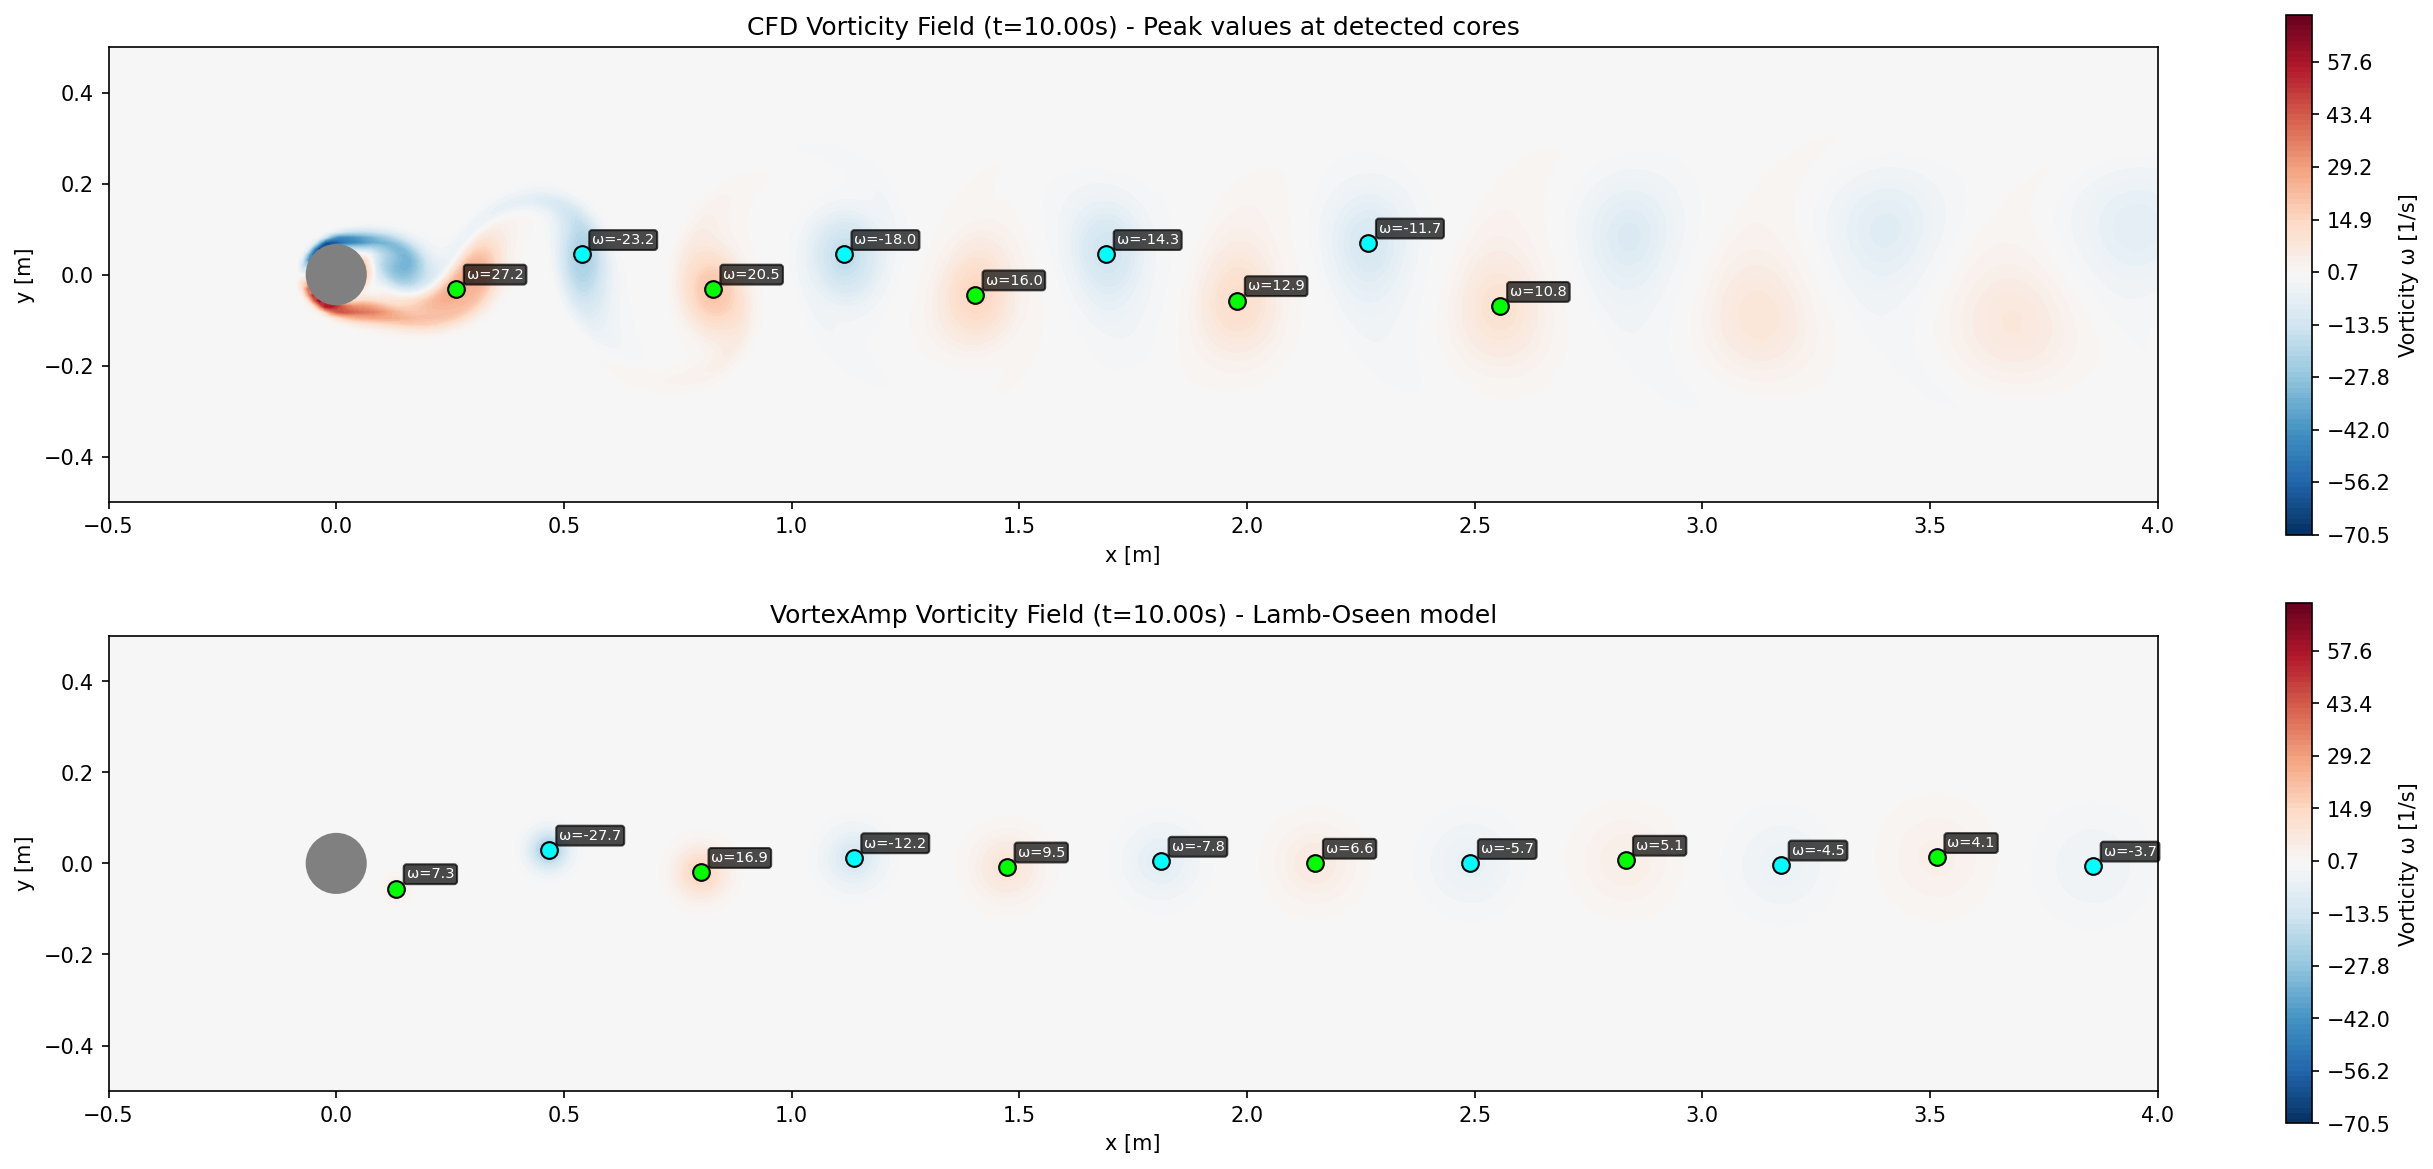

In [62]:
# =============================================================================
# VORTICITY FIELD VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(18, 8))

# --- CFD Vorticity Field ---
ax1 = axes[0]
vort_max = max(abs(cfd_vorticity.min()), abs(cfd_vorticity.max()))
levels = np.linspace(-vort_max, vort_max, 100)
contour1 = ax1.contourf(cfd_X, cfd_Y, cfd_vorticity, levels=levels, cmap='RdBu_r')
plt.colorbar(contour1, ax=ax1, label='Vorticity ω [1/s]')

# Mark detected vortex cores
for v in cfd_vortex_data:
    color = 'lime' if v['sign'] > 0 else 'cyan'
    ax1.plot(v['x'], v['y'], 'o', color=color, markersize=8, markeredgecolor='black', markeredgewidth=1)
    ax1.annotate(f"ω={v['omega_peak']:.1f}", (v['x'], v['y']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=7, color='white',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

circle1 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax1.add_patch(circle1)
ax1.set_xlim(-0.5, 4.0)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_title(f'CFD Vorticity Field (t={cfd_time:.2f}s) - Peak values at detected cores')
ax1.set_aspect('equal')

# --- VortexAmp Vorticity Field (reconstructed from vortices) ---
ax2 = axes[1]

# Create a fine grid for vorticity visualization
x_vm_fine = np.linspace(-0.5, 4.0, 400)
y_vm_fine = np.linspace(-0.5, 0.5, 90)
X_vm_fine, Y_vm_fine = np.meshgrid(x_vm_fine, y_vm_fine)

# Compute vorticity from Lamb-Oseen vortices: omega = (Gamma / pi*sigma^2) * exp(-r^2/sigma^2)
vm_vorticity = np.zeros_like(X_vm_fine)
for v in vm_vortex_field:
    r2 = (X_vm_fine - v['x'])**2 + (Y_vm_fine - v['y'])**2
    sigma2 = v['sigma']**2
    omega_contribution = (v['gamma'] / (np.pi * sigma2)) * np.exp(-r2 / sigma2)
    vm_vorticity += omega_contribution

contour2 = ax2.contourf(X_vm_fine, Y_vm_fine, vm_vorticity, levels=levels, cmap='RdBu_r')
plt.colorbar(contour2, ax=ax2, label='Vorticity ω [1/s]')

# Mark vortex positions
for v in vm_vortex_field:
    color = 'lime' if v['gamma'] > 0 else 'cyan'
    ax2.plot(v['x'], v['y'], 'o', color=color, markersize=8, markeredgecolor='black', markeredgewidth=1)
    omega_peak = v['gamma'] / (np.pi * v['sigma']**2)
    ax2.annotate(f"ω={omega_peak:.1f}", (v['x'], v['y']),
                 xytext=(5, 5), textcoords='offset points', fontsize=7, color='white',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

circle2 = Circle((0, 0), CYLINDER_RADIUS, color='gray', fill=True, zorder=10, edgecolor='black', linewidth=2)
ax2.add_patch(circle2)
ax2.set_xlim(-0.5, 4.0)
ax2.set_ylim(-0.5, 0.5)
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_title(f'VortexAmp Vorticity Field (t={vm_snapshot_time:.2f}s) - Lamb-Oseen model')
ax2.set_aspect('equal')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/10_vorticity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# =============================================================================
# VORTICITY STRENGTH SUMMARY COMPARISON
# =============================================================================

print("\n" + "=" * 70)
print("VORTICITY STRENGTH COMPARISON SUMMARY")
print("=" * 70)

# CFD statistics
cfd_omega_peaks = np.array([v['omega_peak'] for v in cfd_vortex_data])
cfd_mean_omega = np.abs(cfd_omega_peaks).mean() if len(cfd_omega_peaks) > 0 else 0
cfd_mean_gamma = np.abs(cfd_circulations).mean() if len(cfd_circulations) > 0 else 0

# VortexAmp statistics  
vm_mean_omega = np.abs(vm_omega_peaks).mean()
vm_mean_gamma = np.abs(vm_gammas).mean()

print(f"\n{'Property':<30} {'CFD':<15} {'VortexAmp':<15} {'Theory':<15}")
print("-" * 75)
print(f"{'Number of vortices':<30} {len(cfd_vortex_data):<15} {len(vm_vortex_field):<15} {'-':<15}")
print(f"{'Mean |Γ| [m²/s]':<30} {cfd_mean_gamma:<15.4f} {vm_mean_gamma:<15.4f} {Gamma_theory:<15.4f}")
print(f"{'Mean |ω_peak| [1/s]':<30} {cfd_mean_omega:<15.2f} {vm_mean_omega:<15.2f} {'-':<15}")

if len(cfd_circulations) > 0:
    # Individual vortex comparison (match by x-location)
    print(f"\n--- Individual Vortex Circulation Comparison ---")
    print(f"{'x [m]':<10} {'CFD Γ [m²/s]':<15} {'VM Γ [m²/s]':<15} {'Diff [%]':<10}")
    print("-" * 50)
    
    # Sort both by x-position for comparison
    cfd_sorted = sorted(zip(cfd_vortex_data, cfd_circulations), key=lambda x: x[0]['x'])
    vm_sorted = sorted(zip(vm_vortex_field, vm_gammas), key=lambda x: x[0]['x'])
    
    # Match nearest vortices
    for cfd_v, cfd_g in cfd_sorted[:6]:  # Show first 6
        # Find nearest VM vortex
        best_match = None
        best_dist = float('inf')
        for vm_v, vm_g in vm_sorted:
            dist = abs(vm_v['x'] - cfd_v['x']) + abs(vm_v['y'] - cfd_v['y'])
            if dist < best_dist and np.sign(vm_g) == np.sign(cfd_g):
                best_dist = dist
                best_match = (vm_v, vm_g)
        
        if best_match and best_dist < 0.5:  # Match within 0.5m
            vm_v, vm_g = best_match
            diff = (abs(vm_g) - abs(cfd_g)) / abs(cfd_g) * 100 if cfd_g != 0 else 0
            print(f"{cfd_v['x']:<10.2f} {cfd_g:<15.4f} {vm_g:<15.4f} {diff:<+10.1f}")

# Error metrics
print(f"\n--- Error Metrics ---")
gamma_error = (vm_mean_gamma - cfd_mean_gamma) / cfd_mean_gamma * 100 if cfd_mean_gamma > 0 else 0
gamma_error_theory = (vm_mean_gamma - Gamma_theory) / Gamma_theory * 100
print(f"VortexAmp vs CFD:    Mean |Γ| error = {gamma_error:+.1f}%")
print(f"VortexAmp vs Theory: Mean |Γ| error = {gamma_error_theory:+.1f}%")
print(f"CFD vs Theory:       Mean |Γ| error = {(cfd_mean_gamma - Gamma_theory) / Gamma_theory * 100:+.1f}%")

print(f"\n--- Assessment ---")
if abs(gamma_error) < 30:
    print(f"✓ VortexAmp circulation is within acceptable range of CFD ({gamma_error:+.1f}%)")
else:
    print(f"⚠ VortexAmp circulation differs significantly from CFD ({gamma_error:+.1f}%)")
    
if abs(gamma_error_theory) < 30:
    print(f"✓ VortexAmp circulation follows theoretical scaling ({gamma_error_theory:+.1f}%)")
else:
    print(f"⚠ VortexAmp circulation deviates from theory ({gamma_error_theory:+.1f}%)")

print("\n" + "=" * 70)


VORTICITY STRENGTH COMPARISON SUMMARY

Property                       CFD             VortexAmp       Theory         
---------------------------------------------------------------------------
Number of vortices             9               25              -              
Mean |Γ| [m²/s]                0.4686          0.1392          0.1444         
Mean |ω_peak| [1/s]            17.17           5.71            -              

--- Individual Vortex Circulation Comparison ---
x [m]      CFD Γ [m²/s]    VM Γ [m²/s]     Diff [%]  
--------------------------------------------------
0.26       0.7321          0.0136          -98.1     
0.54       -0.4818         -0.1440         -70.1     
0.83       0.4573          0.1444          -68.4     
1.12       -0.4458         -0.1444         -67.6     
1.40       0.4386          0.1444          -67.1     
1.69       -0.4326         -0.1444         -66.6     

--- Error Metrics ---
VortexAmp vs CFD:    Mean |Γ| error = -70.3%
VortexAmp vs Theory: 